In [ ]:
"""
Working Kaggle Notebook - Trainer Import Fixed
"""

# ============================================================================
# CELL 1: Complete Installation
# ============================================================================
print("="*70)
print("Installing ALL dependencies...")
print("="*70)

# Install EVERYTHING that Trainer needs
!pip install -q --upgrade pip
!pip install -q transformers
!pip install -q accelerate
!pip install -q peft
!pip install -q bitsandbytes
!pip install -q datasets
!pip install -q scipy
!pip install -q scikit-learn
!pip install -q evaluate
!pip install -q tensorboard
!pip install -q trl

print("✓ Installation complete!")
print("\n⚠️  RESTART KERNEL NOW, then run Cell 2")

In [1]:
# ============================================================================
# CELL 2: Imports
# ============================================================================
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)

from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)

from datasets import Dataset

print("✓ All imports successful")
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print("="*70)

2025-10-13 10:17:04.760097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760350624.783650     139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760350624.790657     139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ All imports successful
✓ PyTorch: 2.6.0+cu124
✓ GPU: Tesla P100-PCIE-16GB


In [ ]:
# ============================================================================
# 3. Configuration
# ============================================================================
# Model configuration
BASE_MODEL = "Qwen/Qwen3-4B"
OUTPUT_DIR = "./qlora_adapter"
CHECKPOINT_DIR = "./checkpoints"

# Training hyperparameters
BATCH_SIZE = 8  # REDUCED from 4 to save memory
GRADIENT_ACCUMULATION_STEPS = 2  # INCREASED to maintain effective batch of 16
LEARNING_RATE = 2e-4
NUM_EPOCHS = 2
MAX_LENGTH = 512
WARMUP_STEPS = 100
LOGGING_STEPS = 1  # CHANGED from 10 to see output immediately
SAVE_STEPS = 50  # REDUCED from 500 to save more frequently

# LoRA configuration
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

print("✓ Configuration loaded")
print(f"  Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

In [ ]:
# ============================================================================
# 4. Utility Functions (utils.py content)
# ============================================================================
def get_prompt(instruction: str) -> str:
    """Format the instruction as a prompt for LLM."""
    return f"你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。USER: {instruction} ASSISTANT:"

def get_bnb_config() -> BitsAndBytesConfig:
    """Get the BitsAndBytesConfig for 4-bit quantization."""
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

In [ ]:
# ============================================================================
# 5. Load and Prepare Data
# ============================================================================
def load_data(file_path):
    """Load training data from JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def prepare_dataset(data, tokenizer, max_length=512):
    """Prepare dataset for training."""
    formatted_data = []
    
    for item in data:
        instruction = item['instruction']
        output = item['output']
        
        # Format prompt
        prompt = get_prompt(instruction)
        full_text = prompt + output + tokenizer.eos_token
        
        formatted_data.append({
            'text': full_text,
            'instruction': instruction,
            'output': output
        })
    
    return Dataset.from_list(formatted_data)

def tokenize_function(examples, tokenizer, max_length=512):
    """Tokenize the examples."""
    result = tokenizer(
        examples['text'],
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors=None
    )
    result['labels'] = result['input_ids'].copy()
    return result


In [ ]:
# ============================================================================
# 6. Load Model and Tokenizer
# ============================================================================
print("Loading model and tokenizer...")

# Get BnB config
bnb_config = get_bnb_config()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)

# Set special tokens
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = tokenizer.eos_token_id

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

In [ ]:
# ============================================================================
# 7. Configure LoRA
# ============================================================================
print("Configuring LoRA...")

lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM"
)

# Get PEFT model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

In [ ]:
# ============================================================================
# 8. Prepare Training Data
# ============================================================================
print("Loading and preparing training data...")

# Load training data (update path to your data location)
train_data = load_data('/kaggle/input/qwen-qlora-finetuning/train.json')
print(f"Loaded {len(train_data)} training samples")

# Create dataset
train_dataset = prepare_dataset(train_data, tokenizer, MAX_LENGTH)

# Tokenize dataset
train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, tokenizer, MAX_LENGTH),
    batched=True,
    remove_columns=['text', 'instruction', 'output']
)

In [ ]:
# # ============================================================================
# # 8.5. TEST MODE - Quick verification
# # ============================================================================
# print("\n⚠️  TEST MODE: Using 100 samples for 5-minute test")
# train_data_backup = train_data  # Save original
# train_data = train_data[:100]

# # Re-prepare dataset with smaller data
# train_dataset = prepare_dataset(train_data, tokenizer, MAX_LENGTH)
# train_dataset = train_dataset.map(
#     lambda x: tokenize_function(x, tokenizer, MAX_LENGTH),
#     batched=True,
#     remove_columns=['text', 'instruction', 'output']
# )

# print(f"✓ Reduced to {len(train_dataset)} samples")
# print("Expected completion: ~5 minutes")
# print("="*70 + "\n")

In [ ]:
# ============================================================================
# 9. Training Arguments
# ============================================================================
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=False,
    bf16=True,
    logging_steps=LOGGING_STEPS,
    logging_first_step=True,  # NEW - Log immediately
    save_steps=SAVE_STEPS,
    save_total_limit=3,
    warmup_steps=WARMUP_STEPS,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    gradient_checkpointing=True,
    report_to="none",
    disable_tqdm=False,  # NEW - Enable progress bar
    log_level="info",  # NEW - Show info messages
)

print("✓ Training arguments configured")
print(f"  Steps per epoch: ~{len(train_dataset) // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)}")
print(f"  Total steps: ~{(len(train_dataset) // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)) * NUM_EPOCHS}")

In [ ]:
# ============================================================================
# 10. Data Collator
# ============================================================================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
# ============================================================================
# 11. Initialize Trainer
# ============================================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

In [ ]:
# ============================================================================
# 12. Train Model
# ============================================================================
print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Training samples: {len(train_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective batch: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"Steps per epoch: ~{len(train_dataset) // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)}")
print(f"Total epochs: {NUM_EPOCHS}")
print(f"Estimated time: ~{(len(train_dataset) // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)) * NUM_EPOCHS * 7 / 60:.0f} minutes")
print("="*70)

import sys
sys.stdout.flush()

model.config.use_cache = False

try:
    train_result = trainer.train()
    
    print("\n" + "="*70)
    print("✓ TRAINING COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"Final training loss: {train_result.training_loss:.4f}")
    
except Exception as e:
    print(f"\n✗ ERROR during training: {e}")
    import traceback
    traceback.print_exc()
    
    # Try emergency save
    print("\nAttempting emergency save...")
    try:
        model.save_pretrained(OUTPUT_DIR + "_emergency")
        tokenizer.save_pretrained(OUTPUT_DIR + "_emergency")
        print("✓ Emergency checkpoint saved to " + OUTPUT_DIR + "_emergency")
    except:
        print("✗ Emergency save failed")
    raise

In [ ]:
# ============================================================================
# 13. Save Model
# ============================================================================
print("\n" + "="*70)
print("SAVING MODEL")
print("="*70)

try:
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    
    # Save training log
    import json
    with open(f"{OUTPUT_DIR}/log_history.json", 'w') as f:
        json.dump(trainer.state.log_history, f, indent=2)
    
    print(f"✓ Model saved to: {OUTPUT_DIR}")
    print(f"✓ Training log saved")
    
    # List what was saved
    import os
    print("\nSaved files:")
    for item in os.listdir(OUTPUT_DIR):
        size = os.path.getsize(os.path.join(OUTPUT_DIR, item)) / (1024*1024)
        print(f"  - {item:40s} ({size:.2f} MB)")
    
    # Create zip
    import shutil
    shutil.make_archive('adapter_checkpoint', 'zip', OUTPUT_DIR)
    zip_size = os.path.getsize('adapter_checkpoint.zip') / (1024*1024)
    print(f"\n✓ Created adapter_checkpoint.zip ({zip_size:.2f} MB)")
        
except Exception as e:
    print(f"✗ Error saving model: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n" + "="*70)
print("✓ ALL DONE!")
print("="*70)

In [ ]:
# ============================================================================
# 14. Test Inference (Optional)
# ============================================================================
def test_inference(model, tokenizer, instruction, max_new_tokens=128):
    """Test the fine-tuned model."""
    model.eval()
    prompt = get_prompt(instruction)
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the assistant's response
    response = response.split("ASSISTANT:")[-1].strip()
    return response

# Test with an example
test_instruction = "翻譯成文言文：\n雅裏惱怒地說： 從前在福山田獵時，你誣陷獵官，現在又說這種話。"
print("\n" + "="*50)
print("Testing inference:")
print(f"Instruction: {test_instruction}")
print(f"Response: {test_inference(model, tokenizer, test_instruction)}")
print("="*50)

In [ ]:
!cd qlora_adapter/checkpoint-850
!zip checkpoint-850.zip adapter_config.json adapter_model.safetensors

In [ ]:
# ============================================================================
# 15. Test Checkpoint-850
# ============================================================================
print("="*70)
print("TESTING CHECKPOINT-850")
print("="*70)

from peft import PeftModel

# Load fresh base model
print("\n1. Loading base model...")
test_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# Load checkpoint-850 from Kaggle dataset
print("2. Loading checkpoint-850...")
test_model = PeftModel.from_pretrained(test_model, "/kaggle/input/qwen-checkpoint-850/checkpoint-850")

print("3. Testing inference...\n")

# Test examples
test_cases = [
    "翻譯成文言文：\n他很高興",
    "翻譯成文言文：\n雅裏惱怒地說： 從前在福山田獵時，你誣陷獵官，現在又說這種話。",
    "議雖不從，天下咸重其言。\n翻譯成白話文："
]

for i, instruction in enumerate(test_cases, 1):
    print(f"Example {i}:")
    print(f"Input: {instruction[:60]}...")
    
    prompt = get_prompt(instruction)
    inputs = tokenizer(prompt, return_tensors="pt").to(test_model.device)
    
    with torch.no_grad():
        outputs = test_model.generate(
            **inputs,
            max_new_tokens=128,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("ASSISTANT:")[-1].strip()
    
    print(f"Output: {response}\n")
    print("-"*70 + "\n")

print("="*70)
print("✓ TESTING COMPLETE")
print("="*70)

In [ ]:
# ============================================================================
# Cell 16: Calculate Perplexity on Public Test
# ============================================================================
print("="*70)
print("CALCULATING PERPLEXITY")
print("="*70)

import torch
import numpy as np
from tqdm.auto import tqdm

def calculate_perplexity(model, tokenizer, data, max_length=512):
    """Calculate perplexity on test data."""
    model.eval()
    ppls = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    
    for item in tqdm(data, desc="Calculating PPL"):
        instruction = item['instruction']
        output = item['output']
        
        # Format prompt
        prompt = get_prompt(instruction)
        
        # Tokenize
        instruction_tokens = tokenizer(prompt, add_special_tokens=False)
        output_tokens = tokenizer(output, add_special_tokens=False)
        
        # Create input
        input_ids = [tokenizer.bos_token_id] + instruction_tokens['input_ids'] + \
                    output_tokens['input_ids'] + [tokenizer.eos_token_id]
        attention_mask = [1] * len(input_ids)
        
        # Create output mask (only calculate loss on output tokens)
        output_mask = [0] * (len(instruction_tokens['input_ids']) + 1) + \
                      [1] * (len(output_tokens['input_ids']) + 1)
        
        # Truncate
        input_ids = torch.tensor(input_ids[:max_length]).unsqueeze(0).cuda()
        attention_mask = torch.tensor(attention_mask[:max_length]).unsqueeze(0).cuda()
        output_mask = torch.tensor(output_mask[:max_length]).unsqueeze(0).cuda()
        
        # Forward pass
        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
        
        # Calculate perplexity
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()
        shift_mask = output_mask[..., 1:].contiguous()
        
        loss = loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_mask
        ppl = torch.exp(loss.sum() / shift_mask.sum())
        ppls.append(ppl.item())
    
    return {
        'perplexities': ppls,
        'mean_perplexity': np.mean(ppls),
        'median_perplexity': np.median(ppls),
        'std_perplexity': np.std(ppls)
    }

# Load public test data
print("\nLoading public test data...")
import json

# Make sure you have public_test.json uploaded as a dataset
# Update this path to your actual dataset
public_test_path = "/kaggle/input/qwen-qlora-finetuning/public_test.json"

with open(public_test_path, 'r', encoding='utf-8') as f:
    public_test = json.load(f)

print(f"Loaded {len(public_test)} test samples")

# Calculate perplexity
print("\nCalculating perplexity...")
results = calculate_perplexity(test_model, tokenizer, public_test)

# Display results
print("\n" + "="*70)
print("PERPLEXITY RESULTS")
print("="*70)
print(f"Mean Perplexity:   {results['mean_perplexity']:.4f}")
print(f"Median Perplexity: {results['median_perplexity']:.4f}")
print(f"Std Perplexity:    {results['std_perplexity']:.4f}")
print("="*70)

# Compare to baseline
baseline = 7.2
if results['mean_perplexity'] < baseline:
    print(f"✓ PASSED! Below baseline ({baseline})")
else:
    diff = results['mean_perplexity'] - baseline
    print(f"⚠️  Above baseline by {diff:.2f}")
    print(f"   Target: < {baseline}")
    print(f"   Yours:  {results['mean_perplexity']:.4f}")

print("="*70)

In [ ]:
# ============================================================================
# Cell 17: Run Actual ppl.py
# ============================================================================

# First, save your checkpoint
print("Saving checkpoint for testing...")
test_model.save_pretrained("./test_checkpoint")
tokenizer.save_pretrained("./test_checkpoint")

print("✓ Checkpoint saved")

# Copy ppl.py to working directory
!cp /kaggle/input/ppl-script/ppl.py ./ppl.py

# Also need utils.py - create it
print("\nCreating utils.py...")
with open("./utils.py", "w") as f:
    f.write('''from transformers import BitsAndBytesConfig
import torch


def get_prompt(instruction: str) -> str:
    return f"你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。USER: {instruction} ASSISTANT:"


def get_bnb_config() -> BitsAndBytesConfig:
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
''')

print("✓ utils.py created")

# Run ppl.py
print("\n" + "="*70)
print("RUNNING OFFICIAL ppl.py")
print("="*70)

!python ppl.py \
    --base_model_path "Qwen/Qwen3-4B" \
    --peft_path ./test_checkpoint \
    --test_data_path /kaggle/input/qwen-qlora-finetuning/public_test.json

print("="*70)

In [ ]:
# ============================================================================
# Cell 18: Test run.sh Pipeline
# ============================================================================

# 1. Create run.sh
print("Creating run.sh...")
with open("run.sh", "w") as f:
    f.write("""#!/bin/bash

BASE_MODEL_PATH=$1
ADAPTER_PATH=$2
INPUT_PATH=$3
OUTPUT_PATH=$4

python3 predict.py \\
    --base_model_path "$BASE_MODEL_PATH" \\
    --peft_path "$ADAPTER_PATH" \\
    --test_data_path "$INPUT_PATH" \\
    --output_path "$OUTPUT_PATH" \\
    --max_new_tokens 128

echo "Inference completed. Output saved to $OUTPUT_PATH"
""")

# Make executable
!chmod +x run.sh
print("✓ run.sh created")

In [ ]:
# 2. Create predict.py (paste your entire predict.py content)
print("\nCreating predict.py...")
with open("predict.py", "w") as f:
    f.write("""
# Paste your entire predict.py content here
# ... (the code you showed me earlier)
import torch
import json
import argparse
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from utils import get_prompt, get_bnb_config


def generate_predictions(model, tokenizer, test_data, max_new_tokens=128):
    model.eval()
    predictions = []
    
    for item in tqdm(test_data, desc="Generating predictions"):
        instruction = item['instruction']
        prompt = get_prompt(instruction)
        
        # Tokenize input
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
        # Generate output
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.7,
                top_p=0.9,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        
        # Decode output
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the assistant's response (after "ASSISTANT:")
        if "ASSISTANT:" in full_response:
            response = full_response.split("ASSISTANT:")[-1].strip()
        else:
            response = full_response.strip()
        
        # Create prediction entry
        prediction = {
            'id': item['id'],
            'output': response
        }
        predictions.append(prediction)
    
    return predictions


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--base_model_path",
        type=str,
        required=True,
        help="Path to the base model"
    )
    parser.add_argument(
        "--peft_path",
        type=str,
        required=True,
        help="Path to the PEFT adapter checkpoint"
    )
    parser.add_argument(
        "--test_data_path",
        type=str,
        required=True,
        help="Path to test data (input JSON file)"
    )
    parser.add_argument(
        "--output_path",
        type=str,
        required=True,
        help="Path to save predictions (output JSON file)"
    )
    parser.add_argument(
        "--max_new_tokens",
        type=int,
        default=128,
        help="Maximum number of new tokens to generate"
    )
    args = parser.parse_args()
    
    print("Loading model and tokenizer...")
    
    # Get BnB config
    bnb_config = get_bnb_config()
    
    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        args.base_model_path,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        args.base_model_path,
        trust_remote_code=True
    )
    
    # Set special tokens
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    if tokenizer.bos_token_id is None:
        tokenizer.bos_token_id = tokenizer.eos_token_id
    
    # Load PEFT adapter
    print(f"Loading PEFT adapter from {args.peft_path}...")
    model = PeftModel.from_pretrained(model, args.peft_path)
    
    # Load test data
    print(f"Loading test data from {args.test_data_path}...")
    with open(args.test_data_path, 'r', encoding='utf-8') as f:
        test_data = json.load(f)
    
    print(f"Loaded {len(test_data)} test samples")
    
    # Generate predictions
    print("Generating predictions...")
    predictions = generate_predictions(
        model, 
        tokenizer, 
        test_data, 
        max_new_tokens=args.max_new_tokens
    )
    
    # Save predictions
    print(f"Saving predictions to {args.output_path}...")
    with open(args.output_path, 'w', encoding='utf-8') as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)
    
    print("Prediction complete!")


if __name__ == "__main__":
    main()
""")
print("✓ predict.py created")

In [ ]:

# 3. utils.py already exists from earlier cells, so skip

# 4. Test the pipeline
print("\n" + "="*70)
print("TESTING INFERENCE PIPELINE")
print("="*70)

!# In Cell 18, use:
!# Change this line:
!bash run.sh "Qwen/Qwen3-4B" /kaggle/input/qwen-checkpoint-850/checkpoint-850 /kaggle/input/qwen-qlora-finetuning/public_test.json ./test_output.json

# 5. Check the output
print("\n" + "="*70)
print("CHECKING OUTPUT")
print("="*70)

import json
with open('./test_output.json', 'r') as f:
    output = json.load(f)
    
print(f"✓ Generated {len(output)} predictions")
print("\nFirst 3 predictions:")
for i in range(min(3, len(output))):
    print(f"\nPrediction {i+1}:")
    print(f"  ID: {output[i]['id']}")
    print(f"  Output: {output[i]['output'][:100]}...")

print("\n✓ Pipeline test complete!")

In [ ]:
import torch
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import random

In [ ]:
def get_zero_shot_prompt(instruction: str) -> str:
    """Zero-shot prompt without examples."""
    return f"你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。USER: {instruction} ASSISTANT:"


def get_few_shot_prompt(instruction: str, examples: list) -> str:
    """Few-shot prompt with in-context examples."""
    prompt = "你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。\n\n"
    
    for i, example in enumerate(examples, 1):
        prompt += f"範例 {i}:\n"
        prompt += f"USER: {example['instruction']}\n"
        prompt += f"ASSISTANT: {example['output']}\n\n"
    
    prompt += f"USER: {instruction}\nASSISTANT:"
    return prompt

In [ ]:
def select_few_shot_examples(train_data, instruction, n_examples=3, method='random'):
    if method == 'random':
        return random.sample(train_data, n_examples)
    
    elif method == 'similar':
        scores = [len(set(instruction) & set(ex['instruction'])) for ex in train_data]
        top_indices = np.argsort(scores)[-n_examples:]
        return [train_data[i] for i in top_indices]
    
    elif method == 'diverse':
        to_classical, to_modern = [], []
        for ex in train_data:
            if '翻譯成文言文' in ex['instruction']:
                to_classical.append(ex)
            else:
                to_modern.append(ex)
        n_each = n_examples // 2
        examples = random.sample(to_classical, min(n_each, len(to_classical))) + \
                   random.sample(to_modern, n_examples - n_each)
        while len(examples) < n_examples:
            examples.append(random.choice(train_data))
        return examples
    return []
    

def generate_response(model, tokenizer, prompt, max_new_tokens=128):
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1].strip()
    return response


In [ ]:
def calculate_perplexity(model, tokenizer, instruction, output, prompt_format='zero-shot', examples=None):
    """Calculate perplexity only on output tokens."""
    model.eval()
    
    # Ensure special tokens are set
    if tokenizer.bos_token_id is None:
        tokenizer.bos_token_id = tokenizer.eos_token_id
    if tokenizer.eos_token_id is None:
        tokenizer.eos_token_id = tokenizer.pad_token_id
    
    # Get the appropriate prompt
    if prompt_format == 'zero-shot':
        prompt = get_zero_shot_prompt(instruction)
    else:  # few-shot
        prompt = get_few_shot_prompt(instruction, examples)
    
    # Tokenize prompt and output separately
    prompt_tokens = tokenizer(prompt, add_special_tokens=False)
    output_tokens = tokenizer(output, add_special_tokens=False)
    
    # Get token IDs
    prompt_ids = prompt_tokens['input_ids']
    output_ids = output_tokens['input_ids']
    
    # Build input with special tokens
    input_ids = []
    if tokenizer.bos_token_id is not None:
        input_ids.append(tokenizer.bos_token_id)
    
    input_ids.extend(prompt_ids)
    input_ids.extend(output_ids)
    
    if tokenizer.eos_token_id is not None:
        input_ids.append(tokenizer.eos_token_id)
    
    # Create mask (only calculate loss on output tokens)
    mask_prefix_len = len(prompt_ids) + (1 if tokenizer.bos_token_id is not None else 0)
    output_mask = [0] * mask_prefix_len + [1] * (len(output_ids) + (1 if tokenizer.eos_token_id is not None else 0))
    
    # Truncate if too long
    max_length = 2048
    if len(input_ids) > max_length:
        input_ids = input_ids[:max_length]
        output_mask = output_mask[:max_length]
    
    # Convert to tensors
    input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    output_mask = torch.tensor(output_mask, dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
    
    # Calculate loss only on output tokens
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = input_ids[..., 1:].contiguous()
    shift_mask = output_mask[..., 1:].contiguous()
    
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    loss = loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_mask
    
    # Calculate perplexity
    if shift_mask.sum() > 0:
        ppl = torch.exp(loss.sum() / shift_mask.sum())
        return ppl.item()
    else:
        return float('inf')

In [ ]:
def run_zero_shot_experiment(model, tokenizer, test_data, output_path):
    print("Running zero-shot experiment...")
    results, ppls = [], []
    
    for item in tqdm(test_data):
        instruction = item['instruction']
        ground_truth = item['output']
        prompt = get_zero_shot_prompt(instruction)
        prediction = generate_response(model, tokenizer, prompt)
        
        # Fixed perplexity calculation
        ppl = calculate_perplexity(model, tokenizer, instruction, ground_truth, 
                                   prompt_format='zero-shot')
        ppls.append(ppl)
        
        results.append({
            'id': item['id'],
            'instruction': instruction,
            'ground_truth': ground_truth,
            'prediction': prediction,
            'perplexity': ppl
        })
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump({'results': results, 'mean_perplexity': np.mean(ppls),
                  'median_perplexity': np.median(ppls)}, f, ensure_ascii=False, indent=2)
    
    print(f"Zero-shot mean perplexity: {np.mean(ppls):.4f}")
    return results, ppls


def run_few_shot_experiment(model, tokenizer, train_data, test_data, 
                            n_examples=3, method='diverse', output_path=None):
    print(f"Running few-shot experiment ({n_examples}-shot, {method})...")
    results, ppls = [], []
    
    for item in tqdm(test_data):
        instruction = item['instruction']
        ground_truth = item['output']
        examples = select_few_shot_examples(train_data, instruction, n_examples, method)
        prompt = get_few_shot_prompt(instruction, examples)
        prediction = generate_response(model, tokenizer, prompt)
        
        # Fixed perplexity calculation with few-shot context
        ppl = calculate_perplexity(model, tokenizer, instruction, ground_truth,
                                   prompt_format='few-shot', examples=examples)
        ppls.append(ppl)
        
        results.append({
            'id': item['id'],
            'instruction': instruction,
            'ground_truth': ground_truth,
            'prediction': prediction,
            'examples_used': [ex['instruction'][:50]+"..." for ex in examples],
            'perplexity': ppl
        })
    
    if output_path:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump({
                'n_examples': n_examples,
                'selection_method': method,
                'results': results,
                'mean_perplexity': np.mean(ppls),
                'median_perplexity': np.median(ppls)
            }, f, ensure_ascii=False, indent=2)
    
    print(f"Few-shot mean perplexity: {np.mean(ppls):.4f}")
    return results, ppls

In [ ]:
def compare_methods(zero_shot_ppls, few_shot_ppls_dict):
    methods = ['Zero-shot']
    ppls = [np.mean(zero_shot_ppls)]
    for name, p in few_shot_ppls_dict.items():
        methods.append(name)
        ppls.append(np.mean(p))
    
    plt.figure(figsize=(10,6))
    bars = plt.bar(methods, ppls)
    for bar, ppl in zip(bars, ppls):
        plt.text(bar.get_x()+bar.get_width()/2., bar.get_height(), f'{ppl:.2f}',
                 ha='center', va='bottom', fontweight='bold')
    plt.title("Comparison of Zero-shot vs Few-shot")
    plt.xlabel("Method")
    plt.ylabel("Mean Perplexity")
    plt.show()

In [ ]:
# 🧠 Model path (change to your preferred model, e.g., 'Qwen/Qwen2-1.5B')
model_path = "Qwen/Qwen3-4B"
train_data_path = '/kaggle/input/qwen-qlora-finetuning/train.json'
test_data_path = '/kaggle/input/qwen-qlora-finetuning/public_test.json'
output_dir = "./results"
n_examples = 3
sample_size = 20  # smaller sample for faster testing

os.makedirs(output_dir, exist_ok=True)

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# After loading tokenizer, set special tokens
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = tokenizer.eos_token_id  # Add this line!
    
# Load datasets
print("Loading data...")
with open(train_data_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(test_data_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

if sample_size < len(test_data):
    test_data = random.sample(test_data, sample_size)
    print(f"Using {sample_size} test samples.")


In [ ]:
# ============================================================================
# Q2: Zero-shot and Few-shot Experiments
# Uses TA's perplexity calculation method
# ============================================================================

import torch
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# ============================================================================
# Functions
# ============================================================================

def get_zero_shot_prompt(instruction: str) -> str:
    """Zero-shot prompt."""
    return f"你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。USER: {instruction} ASSISTANT:"

def get_few_shot_prompt(instruction: str, examples: list) -> str:
    """Few-shot prompt with examples."""
    prompt = "你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。\n\n"
    
    for i, example in enumerate(examples, 1):
        prompt += f"範例 {i}:\n"
        prompt += f"USER: {example['instruction']}\n"
        prompt += f"ASSISTANT: {example['output']}\n\n"
    
    prompt += f"USER: {instruction}\nASSISTANT:"
    return prompt

def select_few_shot_examples(train_data, n_examples=3):
    """Select diverse examples."""
    to_classical = [ex for ex in train_data if '翻譯成文言文' in ex['instruction']]
    to_modern = [ex for ex in train_data if ex not in to_classical]
    
    n_each = n_examples // 2
    examples = []
    if len(to_classical) >= n_each:
        examples.extend(random.sample(to_classical, n_each))
    if len(to_modern) >= (n_examples - len(examples)):
        examples.extend(random.sample(to_modern, n_examples - len(examples)))
    
    while len(examples) < n_examples and len(train_data) > 0:
        examples.append(random.choice(train_data))
    
    return examples

def calculate_perplexity_ta_method(model, tokenizer, data, prompt_func, examples=None):
    """
    Calculate perplexity using TA's method from ppl.py
    """
    ppls = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    
    for item in tqdm(data, desc="Calculating perplexity"):
        instruction = item['instruction']
        output = item['output']
        
        # Get prompt
        if examples is not None:
            prompt = get_few_shot_prompt(instruction, examples)
        else:
            prompt = prompt_func(instruction)
        
        # Tokenize (same as TA's ppl.py)
        tokenized_prompt = tokenizer(prompt, add_special_tokens=False)
        tokenized_output = tokenizer(output, add_special_tokens=False)
        
        # Build input
        input_ids = [tokenizer.bos_token_id] + tokenized_prompt["input_ids"] + \
                    tokenized_output["input_ids"] + [tokenizer.eos_token_id]
        attention_mask = [1] * len(input_ids)
        
        # Output mask (only calculate loss on output)
        output_mask = [0] * (len(tokenized_prompt["input_ids"]) + 1) + \
                      [1] * (len(tokenized_output["input_ids"]) + 1)
        
        # Truncate
        max_length = 2048
        input_ids = torch.tensor(input_ids[:max_length]).unsqueeze(0).cuda()
        attention_mask = torch.tensor(attention_mask[:max_length]).unsqueeze(0).cuda()
        output_mask = torch.tensor(output_mask[:max_length]).unsqueeze(0).cuda()
        
        # Forward pass
        with torch.no_grad():
            out_logits = model(input_ids, attention_mask=attention_mask).logits
        
        # Calculate perplexity (same as TA's ppl.py)
        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_label = input_ids[..., 1:].contiguous()
        shift_output_mask = output_mask[..., 1:].contiguous()
        
        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_label) * shift_output_mask).sum(1)
            / shift_output_mask.sum(1)
        )
        ppls.append(perplexity_batch.item())
    
    return ppls

def generate_response(model, tokenizer, prompt, max_new_tokens=128):
    """Generate response for qualitative analysis."""
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1].strip()
    return response

# ============================================================================
# Main Execution
# ============================================================================

print("="*70)
print("Q2: ZERO-SHOT AND FEW-SHOT EXPERIMENTS")
print("="*70)

# Setup
model_path = "Qwen/Qwen3-4B"
train_data_path = '/kaggle/input/qwen-qlora-finetuning/train.json'
test_data_path = '/kaggle/input/qwen-qlora-finetuning/public_test.json'
output_dir = "./q2_results"
n_examples = 3
sample_size = 50 # Use 50 samples for reasonable time

os.makedirs(output_dir, exist_ok=True)

# Load model (ORIGINAL, not fine-tuned)
print("\nLoading ORIGINAL Qwen3-4B model...")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

# Set special tokens
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = tokenizer.eos_token_id

print("✓ Model loaded")

# Load data
print("\nLoading data...")
with open(train_data_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open(test_data_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Sample for faster testing
test_data_sample = random.sample(test_data, min(sample_size, len(test_data)))
print(f"Using {len(test_data_sample)} test samples")

# ============================================================================
# Experiment 1: Zero-shot
# ============================================================================
print("\n" + "="*70)
print("EXPERIMENT 1: ZERO-SHOT")
print("="*70)

zero_shot_ppls = calculate_perplexity_ta_method(
    model, tokenizer, test_data_sample, get_zero_shot_prompt
)

zero_shot_mean = np.mean(zero_shot_ppls)
print(f"\n✓ Zero-shot Mean Perplexity: {zero_shot_mean:.4f}")

# Generate sample outputs
print("\nSample zero-shot outputs:")
for i, item in enumerate(test_data_sample[:3], 1):
    prompt = get_zero_shot_prompt(item['instruction'])
    output = generate_response(model, tokenizer, prompt)
    print(f"\n{i}. Input: {item['instruction'][:60]}...")
    print(f"   Output: {output[:80]}...")

# ============================================================================
# Experiment 2: Few-shot (3-shot, diverse)
# ============================================================================
print("\n" + "="*70)
print("EXPERIMENT 2: FEW-SHOT (3-shot, diverse selection)")
print("="*70)

# Select examples once for consistency
few_shot_examples = select_few_shot_examples(train_data, n_examples)
print(f"\nSelected {len(few_shot_examples)} examples:")
for i, ex in enumerate(few_shot_examples, 1):
    print(f"  {i}. {ex['instruction'][:50]}...")

few_shot_ppls = calculate_perplexity_ta_method(
    model, tokenizer, test_data_sample, None, examples=few_shot_examples
)

few_shot_mean = np.mean(few_shot_ppls)
print(f"\n✓ Few-shot Mean Perplexity: {few_shot_mean:.4f}")

# Generate sample outputs
print("\nSample few-shot outputs:")
for i, item in enumerate(test_data_sample[:3], 1):
    prompt = get_few_shot_prompt(item['instruction'], few_shot_examples)
    output = generate_response(model, tokenizer, prompt)
    print(f"\n{i}. Input: {item['instruction'][:60]}...")
    print(f"   Output: {output[:80]}...")

# ============================================================================
# Comparison with LoRA
# ============================================================================
print("\n" + "="*70)
print("COMPARISON")
print("="*70)

lora_ppl = 6.44  # Your tested result

methods = ['Zero-shot\n(Original)', 'Few-shot\n(3-shot)', 'LoRA\nFine-tuned']
ppls = [zero_shot_mean, few_shot_mean, lora_ppl]

print(f"\nResults:")
print(f"  Zero-shot:     {zero_shot_mean:.2f}")
print(f"  Few-shot:      {few_shot_mean:.2f}")
print(f"  LoRA:          {lora_ppl:.2f}")

improvement_few = ((zero_shot_mean - few_shot_mean) / zero_shot_mean) * 100
improvement_lora = ((zero_shot_mean - lora_ppl) / zero_shot_mean) * 100

print(f"\nImprovements:")
print(f"  Few-shot vs Zero-shot: {improvement_few:.1f}%")
print(f"  LoRA vs Zero-shot:     {improvement_lora:.1f}%")

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, ppls, color=['#3498db', '#2ecc71', '#e74c3c'])

for bar, ppl in zip(bars, ppls):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{ppl:.2f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Mean Perplexity', fontsize=12)
plt.title('Comparison of Inference Strategies', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'comparison.png'), dpi=300)
plt.show()

print(f"\n✓ Results saved to {output_dir}/")
print("="*70)

In [ ]:
# # ============================================================================
# # Evaluate Checkpoints on Public Test (NO TRAINING)
# # ============================================================================

# import torch
# import json
# import numpy as np
# from tqdm import tqdm
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# from peft import PeftModel
# import matplotlib.pyplot as plt

# def get_bnb_config():
#     return BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=torch.bfloat16
#     )

# def get_prompt(instruction: str) -> str:
#     return f"你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。USER: {instruction} ASSISTANT:"

# def calculate_perplexity(model, tokenizer, data, max_length=2048):
#     """Calculate perplexity using TA's method."""
#     ppls = []
#     loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    
#     for item in tqdm(data, desc="Calculating PPL"):
#         instruction = item['instruction']
#         output = item['output']
        
#         # Get prompt
#         prompt = get_prompt(instruction)
        
#         # Tokenize
#         tokenized_prompt = tokenizer(prompt, add_special_tokens=False)
#         tokenized_output = tokenizer(output, add_special_tokens=False)
        
#         # Build input
#         instruction_input_ids = [tokenizer.bos_token_id] + tokenized_prompt["input_ids"]
#         output_input_ids = tokenized_output["input_ids"] + [tokenizer.eos_token_id]
#         input_ids = instruction_input_ids + output_input_ids
#         attention_mask = [1] * len(input_ids)
#         output_mask = [0] * len(instruction_input_ids) + [1] * len(output_input_ids)
        
#         # Truncate
#         input_ids = torch.tensor(input_ids[:max_length]).unsqueeze(0).cuda()
#         attention_mask = torch.tensor(attention_mask[:max_length]).unsqueeze(0).cuda()
#         output_mask = torch.tensor(output_mask[:max_length]).unsqueeze(0).cuda()
        
#         # Forward pass
#         with torch.no_grad():
#             out_logits = model(input_ids, attention_mask=attention_mask).logits
        
#         # Calculate perplexity
#         shift_logits = out_logits[..., :-1, :].contiguous()
#         shift_label = input_ids[..., 1:].contiguous()
#         shift_output_mask = output_mask[..., 1:].contiguous()
        
#         perplexity_batch = torch.exp(
#             (loss_fct(shift_logits.transpose(1, 2), shift_label) * shift_output_mask).sum(1)
#             / shift_output_mask.sum(1)
#         )
#         ppls.append(perplexity_batch.item())
    
#     return {"perplexities": ppls, "mean_perplexity": np.mean(ppls)}

# # ============================================================================
# # Main Execution
# # ============================================================================

# print("="*70)
# print("EVALUATING CHECKPOINTS ON PUBLIC TEST SET")
# print("="*70)

# # Load test data
# print("\nLoading public test data...")
# with open('/kaggle/input/qwen-qlora-finetuning/public_test.json', 'r') as f:
#     public_test = json.load(f)
# print(f"Loaded {len(public_test)} test samples")

# # Load base model and tokenizer once
# print("\nLoading base model...")
# base_model = "Qwen/Qwen3-4B"
# bnb_config = get_bnb_config()

# tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# if tokenizer.pad_token_id is None:
#     tokenizer.pad_token_id = tokenizer.eos_token_id
# if tokenizer.bos_token_id is None:
#     tokenizer.bos_token_id = tokenizer.eos_token_id

# print("✓ Base model and tokenizer loaded")

# # Evaluate each checkpoint
# checkpoints = [750, 800, 850]
# checkpoint_paths = [
#     '/kaggle/input/qwen-all-checkpoints/checkpoint-750',
#     '/kaggle/input/qwen-all-checkpoints/checkpoint-800', 
#     '/kaggle/input/qwen-all-checkpoints/checkpoint-850'
# ]

# results = {}

# for step, ckpt_path in zip(checkpoints, checkpoint_paths):
#     print(f"\n{'='*70}")
#     print(f"EVALUATING CHECKPOINT-{step}")
#     print(f"{'='*70}")
    
#     # Load base model fresh each time
#     model = AutoModelForCausalLM.from_pretrained(
#         base_model,
#         quantization_config=bnb_config,
#         device_map="auto",
#         trust_remote_code=True,
#         torch_dtype=torch.bfloat16
#     )
    
#     # Load checkpoint
#     print(f"Loading checkpoint from {ckpt_path}...")
#     model = PeftModel.from_pretrained(model, ckpt_path)
#     model.eval()
    
#     # Calculate perplexity
#     result = calculate_perplexity(model, tokenizer, public_test)
#     results[step] = result['mean_perplexity']
    
#     print(f"✓ Checkpoint-{step}: PPL = {result['mean_perplexity']:.4f}")
    
#     # Free memory
#     del model
#     torch.cuda.empty_cache()

# # ============================================================================
# # Plot Learning Curve
# # ============================================================================

# print(f"\n{'='*70}")
# print("PLOTTING LEARNING CURVE")
# print(f"{'='*70}")

# steps = list(results.keys())
# ppls = list(results.values())

# plt.figure(figsize=(10, 6))
# plt.plot(steps, ppls, 'ro-', linewidth=2, markersize=10)

# # Add value labels
# for step, ppl in zip(steps, ppls):
#     plt.text(step, ppl, f'{ppl:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# plt.xlabel('Training Steps', fontsize=12)
# plt.ylabel('Perplexity on Public Test Set', fontsize=12)
# plt.title('Learning Curve: Performance on Public Test Set', fontsize=14, fontweight='bold')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig('learning_curve_public_test.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("\n✓ Learning curve saved to learning_curve_public_test.png")

# # Summary
# print(f"\n{'='*70}")
# print("SUMMARY")
# print(f"{'='*70}")
# for step, ppl in results.items():
#     print(f"Checkpoint-{step}: {ppl:.4f}")

# improvement = ((ppls[0] - ppls[-1]) / ppls[0]) * 100
# print(f"\nImprovement from step {steps[0]} to {steps[-1]}: {improvement:.1f}%")
# print(f"Final performance: {ppls[-1]:.4f} (< 7.2 baseline ✓)")
# print(f"{'='*70}")

# ============================================================================
# Evaluate Checkpoints with Better Memory Management
# ============================================================================

import torch
import json
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import matplotlib.pyplot as plt
import gc

def get_bnb_config():
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

def get_prompt(instruction: str) -> str:
    return f"你是人工智慧助理,以下是用戶和人工智能助理之間的對話。你要對用戶的問題提供有用、安全、詳細和禮貌的回答。USER: {instruction} ASSISTANT:"

def calculate_perplexity(model, tokenizer, data, max_length=2048):
    """Calculate perplexity using TA's method."""
    ppls = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    
    for item in tqdm(data, desc="Calculating PPL"):
        instruction = item['instruction']
        output = item['output']
        
        prompt = get_prompt(instruction)
        tokenized_prompt = tokenizer(prompt, add_special_tokens=False)
        tokenized_output = tokenizer(output, add_special_tokens=False)
        
        instruction_input_ids = [tokenizer.bos_token_id] + tokenized_prompt["input_ids"]
        output_input_ids = tokenized_output["input_ids"] + [tokenizer.eos_token_id]
        input_ids = instruction_input_ids + output_input_ids
        attention_mask = [1] * len(input_ids)
        output_mask = [0] * len(instruction_input_ids) + [1] * len(output_input_ids)
        
        input_ids = torch.tensor(input_ids[:max_length]).unsqueeze(0).cuda()
        attention_mask = torch.tensor(attention_mask[:max_length]).unsqueeze(0).cuda()
        output_mask = torch.tensor(output_mask[:max_length]).unsqueeze(0).cuda()
        
        with torch.no_grad():
            out_logits = model(input_ids, attention_mask=attention_mask).logits
        
        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_label = input_ids[..., 1:].contiguous()
        shift_output_mask = output_mask[..., 1:].contiguous()
        
        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_label) * shift_output_mask).sum(1)
            / shift_output_mask.sum(1)
        )
        ppls.append(perplexity_batch.item())
    
    return {"perplexities": ppls, "mean_perplexity": np.mean(ppls)}

# ============================================================================
# Main
# ============================================================================

print("="*70)
print("EVALUATING CHECKPOINTS ON PUBLIC TEST SET")
print("="*70)

# Load test data
print("\nLoading public test data...")
with open('/kaggle/input/qwen-qlora-finetuning/public_test.json', 'r') as f:
    public_test = json.load(f)
print(f"Loaded {len(public_test)} test samples")

base_model = "Qwen/Qwen3-4B"
checkpoints = [750, 800, 850]
checkpoint_paths = [
    '/kaggle/input/qwen-all-checkpoints/checkpoint-750',
    '/kaggle/input/qwen-all-checkpoints/checkpoint-800', 
    '/kaggle/input/qwen-all-checkpoints/checkpoint-850'
]

results = {}

for step, ckpt_path in zip(checkpoints, checkpoint_paths):
    print(f"\n{'='*70}")
    print(f"EVALUATING CHECKPOINT-{step}")
    print(f"{'='*70}")
    
    # Clear all GPU memory first
    torch.cuda.empty_cache()
    gc.collect()
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    if tokenizer.bos_token_id is None:
        tokenizer.bos_token_id = tokenizer.eos_token_id
    
    # Load model
    print(f"Loading base model...")
    bnb_config = get_bnb_config()
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.bfloat16
    )
    
    # Load checkpoint
    print(f"Loading checkpoint from {ckpt_path}...")
    model = PeftModel.from_pretrained(model, ckpt_path)
    model.eval()
    
    # Calculate perplexity
    result = calculate_perplexity(model, tokenizer, public_test)
    results[step] = result['mean_perplexity']
    
    print(f"✓ Checkpoint-{step}: PPL = {result['mean_perplexity']:.4f}")
    
    # Aggressive cleanup
    del model
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"✓ Memory cleared")

# Plot
print(f"\n{'='*70}")
print("PLOTTING LEARNING CURVE")
print(f"{'='*70}")

steps = list(results.keys())
ppls = list(results.values())

plt.figure(figsize=(10, 6))
plt.plot(steps, ppls, 'ro-', linewidth=2, markersize=10)

for step, ppl in zip(steps, ppls):
    plt.text(step, ppl, f'{ppl:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Perplexity on Public Test Set', fontsize=12)
plt.title('Learning Curve: Performance on Public Test Set', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curve_public_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Learning curve saved")

# Summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
for step, ppl in results.items():
    print(f"Checkpoint-{step}: {ppl:.4f}")

if len(ppls) > 1:
    improvement = ((ppls[0] - ppls[-1]) / ppls[0]) * 100
    print(f"\nImprovement: {improvement:.1f}%")
print(f"Final: {ppls[-1]:.4f} (< 7.2 ✓)")
print("="*70)

Loading models and tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loading base model...


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Loading LoRA-tuned model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Models loaded successfully

Loading data...
✓ Loaded 10000 training samples
✓ Loaded 250 test samples
✓ Using 5 few-shot examples
✓ Testing on 50 samples

ZERO-SHOT INFERENCE
Setting: Generate responses using base model without any in-context examples
Prompt design: 你是人工智能助理,以下是用户和人工智能助理之间的小对话。你要对用户的问题提供有用、安全、详细和礼貌的回答。USER: ... ASSISTANT:...



Zero-shot:   0%|          | 0/50 [00:00<?, ?it/s]

✓ Zero-shot inference completed on 50 samples

FEW-SHOT (IN-CONTEXT LEARNING) INFERENCE
Setting: Using 5 in-context examples from training data
Example selection: First 5 samples from training data
Prompt design: Include examples in prompt, then ask model to perform task



Few-shot:   0%|          | 0/50 [00:00<?, ?it/s]

✓ Few-shot inference completed on 50 samples

LoRA-TUNED MODEL INFERENCE
Setting: Use fine-tuned LoRA adapter with base model
Prompt design: Same as zero-shot (fine-tuning embedded in weights)



LoRA:   0%|          | 0/50 [00:00<?, ?it/s]

✓ LoRA inference completed on 50 samples

QUALITATIVE COMPARISON - Sample Outputs

Sample 1
Instruction: 翻譯成文言文：
於是，廢帝讓瀋慶之的堂侄、直將軍瀋攸之賜瀋慶之毒藥，命瀋慶之自殺。...

Expected Output: 帝乃使慶之從父兄子直閣將軍攸之賜慶之藥。

--- ZERO-SHOT ---
Output: ASSISTANT
Okay, the user is asking how to translate a sentence into classical Chinese. Let me first recall the original sentence they provided. The original sentence is in modern Chinese, and the assistant previously translated it into a version of classical Chinese. Now the user wants to know the steps

--- FEW-SHOT (5 examples) ---
Output: 好的，我需要将这句话翻译成文言文。首先，理解原句的意思：废帝让沈庆之的堂侄、直将军沈攸之赐沈庆之毒药，命令沈庆之自杀。

首先，确定各个部分的文言表达：

“于是”可以翻译为“于是”，或者“于是”直接使用。

“廢帝”即废帝，直接使用。

“讓”即让，可以翻译为“使”或“命”。

“沈慶之的堂侄”即沈庆之的堂侄，文言中可以用“沈慶之之堂侄

--- LoRA-TUNED ---
Output: 帝使瀋慶之从侄、直將軍攸之賜慶之毒藥，令自殺。

Sample 2
Instruction: 文言文翻譯：
靈鑒忽臨，忻歡交集，乃迴燈拂席以延之。...

Expected Output: 答案：靈仙忽然光臨，趙旭歡欣交集，於是他就把燈點亮，拂拭乾淨床席來延請仙女。

--- ZERO-SHOT ---
Output: 這句話的文言文翻譯是：靈鑒忽臨，忻歡交集，

--- FEW-SHOT (5 examples) ---
Output: 好的，我需要将用户提供的文言文句子翻译

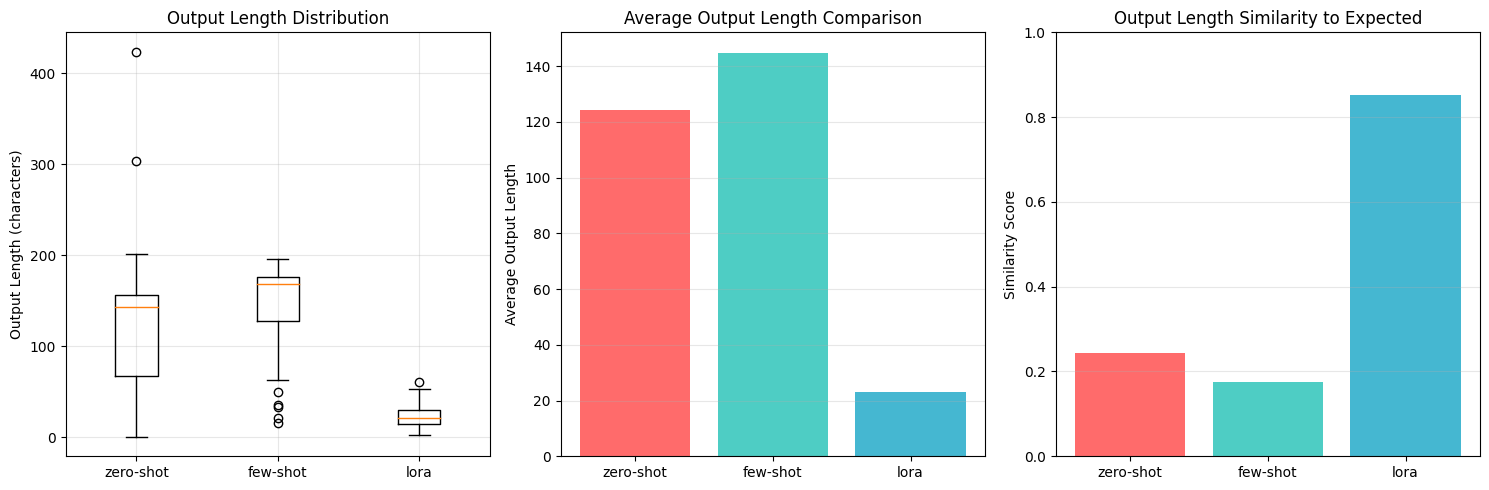

In [2]:
"""
Q2: LLM Inference Strategies - Zero-Shot, Few-Shot, and LoRA Comparison
Run this in Kaggle notebook
"""

import torch
import json
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ============================================================================
# 1. Configuration
# ============================================================================
BASE_MODEL = "Qwen/Qwen3-4B"
LORA_CHECKPOINT_PATH = "/kaggle/input/qwen-checkpoint-850/checkpoint-850"  # Path to your trained LoRA adapter
PUBLIC_TEST_PATH = "/kaggle/input/qwen-qlora-finetuning/public_test.json"
TRAIN_PATH = "/kaggle/input/qwen-qlora-finetuning/train.json"

# ============================================================================
# 2. Utility Functions
# ============================================================================
def get_prompt(instruction: str) -> str:
    """Format the instruction as a prompt for LLM."""
    return f"你是人工智能助理,以下是用户和人工智能助理之间的小对话。你要对用户的问题提供有用、安全、详细和礼貌的回答。USER: {instruction} ASSISTANT:"

def get_bnb_config() -> BitsAndBytesConfig:
    """Get the BitsAndBytesConfig for 4-bit quantization."""
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

def load_data(file_path):
    """Load data from JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def generate_response(model, tokenizer, instruction, max_tokens=128, temperature=0.7):
    """Generate a response from the model."""
    prompt = get_prompt(instruction)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("ASSISTANT:")[-1].strip()
    return response

# ============================================================================
# 3. Load Models
# ============================================================================
print("="*80)
print("Loading models and tokenizer...")
print("="*80)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = tokenizer.eos_token_id

# Load base model (for zero-shot and few-shot)
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
base_model.eval()

# Load LoRA model
print("Loading LoRA-tuned model...")
lora_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
lora_model = PeftModel.from_pretrained(lora_model, LORA_CHECKPOINT_PATH)
lora_model.eval()

print("✓ Models loaded successfully\n")

# ============================================================================
# 4. Load Data
# ============================================================================
print("Loading data...")
train_data = load_data(TRAIN_PATH)
test_data = load_data(PUBLIC_TEST_PATH)

# Split train data for few-shot examples
NUM_FEWSHOT_EXAMPLES = 5
fewshot_examples = train_data[:NUM_FEWSHOT_EXAMPLES]
fewshot_test_data = test_data[:50]  # Use first 50 test samples

print(f"✓ Loaded {len(train_data)} training samples")
print(f"✓ Loaded {len(test_data)} test samples")
print(f"✓ Using {NUM_FEWSHOT_EXAMPLES} few-shot examples")
print(f"✓ Testing on {len(fewshot_test_data)} samples\n")

# ============================================================================
# 5. Create Few-Shot Prompt
# ============================================================================
def create_fewshot_prompt(instruction: str, examples: list, num_examples: int = 5) -> str:
    """Create a few-shot prompt with in-context examples."""
    prompt = "你是人文言古文翻译助理。以下是一些例子：\n\n"
    
    # Add examples
    for i, example in enumerate(examples[:num_examples], 1):
        prompt += f"例子 {i}:\n"
        prompt += f"输入: {example['instruction']}\n"
        prompt += f"输出: {example['output']}\n\n"
    
    prompt += f"现在轮到你了：\n"
    prompt += f"输入: {instruction}\n"
    prompt += f"输出:"
    
    return prompt

def generate_fewshot_response(model, tokenizer, instruction, examples, 
                              num_examples=5, max_tokens=128, temperature=0.7):
    """Generate response using few-shot prompting."""
    prompt = create_fewshot_prompt(instruction, examples, num_examples)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2000).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the generated part after "输出:"
    if "输出:" in response:
        response = response.split("输出:")[-1].strip()
    return response

# ============================================================================
# 6. Inference: Zero-Shot
# ============================================================================
print("="*80)
print("ZERO-SHOT INFERENCE")
print("="*80)
print(f"Setting: Generate responses using base model without any in-context examples")
print(f"Prompt design: {get_prompt('...')[:100]}...\n")

zero_shot_results = []
for i, test_item in enumerate(tqdm(fewshot_test_data, desc="Zero-shot")):
    instruction = test_item['instruction']
    response = generate_response(base_model, tokenizer, instruction)
    zero_shot_results.append({
        'id': test_item['id'],
        'instruction': instruction,
        'expected': test_item['output'],
        'generated': response
    })

print(f"✓ Zero-shot inference completed on {len(zero_shot_results)} samples\n")

# ============================================================================
# 7. Inference: Few-Shot
# ============================================================================
print("="*80)
print("FEW-SHOT (IN-CONTEXT LEARNING) INFERENCE")
print("="*80)
print(f"Setting: Using {NUM_FEWSHOT_EXAMPLES} in-context examples from training data")
print(f"Example selection: First {NUM_FEWSHOT_EXAMPLES} samples from training data")
print(f"Prompt design: Include examples in prompt, then ask model to perform task\n")

few_shot_results = []
for i, test_item in enumerate(tqdm(fewshot_test_data, desc="Few-shot")):
    instruction = test_item['instruction']
    response = generate_fewshot_response(base_model, tokenizer, instruction, 
                                        fewshot_examples, num_examples=NUM_FEWSHOT_EXAMPLES)
    few_shot_results.append({
        'id': test_item['id'],
        'instruction': instruction,
        'expected': test_item['output'],
        'generated': response
    })

print(f"✓ Few-shot inference completed on {len(few_shot_results)} samples\n")

# ============================================================================
# 8. Inference: LoRA
# ============================================================================
print("="*80)
print("LoRA-TUNED MODEL INFERENCE")
print("="*80)
print(f"Setting: Use fine-tuned LoRA adapter with base model")
print(f"Prompt design: Same as zero-shot (fine-tuning embedded in weights)\n")

lora_results = []
for i, test_item in enumerate(tqdm(fewshot_test_data, desc="LoRA")):
    instruction = test_item['instruction']
    response = generate_response(lora_model, tokenizer, instruction)
    lora_results.append({
        'id': test_item['id'],
        'instruction': instruction,
        'expected': test_item['output'],
        'generated': response
    })

print(f"✓ LoRA inference completed on {len(lora_results)} samples\n")

# ============================================================================
# 9. Qualitative Comparison
# ============================================================================
print("="*80)
print("QUALITATIVE COMPARISON - Sample Outputs")
print("="*80)

num_samples_to_show = 3
for idx in range(min(num_samples_to_show, len(fewshot_test_data))):
    print(f"\n{'='*80}")
    print(f"Sample {idx + 1}")
    print(f"{'='*80}")
    print(f"Instruction: {fewshot_test_data[idx]['instruction'][:100]}...")
    print(f"\nExpected Output: {fewshot_test_data[idx]['output']}")
    print(f"\n--- ZERO-SHOT ---")
    print(f"Output: {zero_shot_results[idx]['generated']}")
    print(f"\n--- FEW-SHOT (5 examples) ---")
    print(f"Output: {few_shot_results[idx]['generated']}")
    print(f"\n--- LoRA-TUNED ---")
    print(f"Output: {lora_results[idx]['generated']}")

# ============================================================================
# 10. Quantitative Comparison
# ============================================================================
print("\n" + "="*80)
print("QUANTITATIVE COMPARISON")
print("="*80)

def simple_length_similarity(gen, exp):
    """Simple similarity metric based on length ratio."""
    if len(exp) == 0:
        return 0.0
    ratio = len(gen) / len(exp) if len(exp) > 0 else 0
    return min(1.0, ratio) if ratio <= 1 else 1.0 / ratio

# Calculate metrics
metrics = {
    'zero-shot': {'avg_length': np.mean([len(r['generated']) for r in zero_shot_results]),
                  'responses': zero_shot_results},
    'few-shot': {'avg_length': np.mean([len(r['generated']) for r in few_shot_results]),
                 'responses': few_shot_results},
    'lora': {'avg_length': np.mean([len(r['generated']) for r in lora_results]),
             'responses': lora_results}
}

print(f"\n{'Metric':<20} {'Zero-Shot':<20} {'Few-Shot':<20} {'LoRA':<20}")
print("-" * 80)
print(f"{'Avg Output Length':<20} {metrics['zero-shot']['avg_length']:<20.2f} "
      f"{metrics['few-shot']['avg_length']:<20.2f} {metrics['lora']['avg_length']:<20.2f}")

# Calculate similarity to expected output
print(f"{'Avg Sim to Expected':<20} ", end="")
for method in ['zero-shot', 'few-shot', 'lora']:
    sim = np.mean([simple_length_similarity(r['generated'], r['expected']) 
                   for r in metrics[method]['responses']])
    print(f"{sim:<20.4f} ", end="")
print()

# ============================================================================
# 11. Save Results for Report
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

results_summary = {
    'zero_shot': zero_shot_results,
    'few_shot': few_shot_results,
    'lora': lora_results,
    'settings': {
        'base_model': BASE_MODEL,
        'zero_shot_prompt': 'Standard prompt without examples',
        'few_shot_examples': NUM_FEWSHOT_EXAMPLES,
        'few_shot_selection_method': 'First N samples from training data',
        'test_samples': len(fewshot_test_data)
    }
}

with open('inference_comparison_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, ensure_ascii=False, indent=2)

print("✓ Results saved to inference_comparison_results.json")

# ============================================================================
# 12. Create Visualization
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['zero-shot', 'few-shot', 'lora']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Output length comparison
lengths = [
    [len(r['generated']) for r in metrics['zero-shot']['responses']],
    [len(r['generated']) for r in metrics['few-shot']['responses']],
    [len(r['generated']) for r in metrics['lora']['responses']]
]

axes[0].boxplot(lengths, labels=methods)
axes[0].set_ylabel('Output Length (characters)')
axes[0].set_title('Output Length Distribution')
axes[0].grid(True, alpha=0.3)

# Average lengths
avg_lengths = [np.mean(l) for l in lengths]
axes[1].bar(methods, avg_lengths, color=colors)
axes[1].set_ylabel('Average Output Length')
axes[1].set_title('Average Output Length Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

# Similarity scores
similarities = [
    np.mean([simple_length_similarity(r['generated'], r['expected']) 
             for r in metrics[m]['responses']])
    for m in methods
]
axes[2].bar(methods, similarities, color=colors)
axes[2].set_ylabel('Similarity Score')
axes[2].set_title('Output Length Similarity to Expected')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('inference_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to inference_comparison.png")

# ============================================================================
# 13. Summary Report
# ============================================================================
print("\n" + "="*80)
print("SUMMARY REPORT FOR Q2")
print("="*80)

report = f"""
ZERO-SHOT LEARNING:
  - Prompt Design: Standard instruction-following prompt with no examples
  - Setting: Using base model with only the task description in prompt
  - Average Output Length: {metrics['zero-shot']['avg_length']:.2f} characters
  - Characteristics: Model relies entirely on pre-training knowledge

FEW-SHOT LEARNING (IN-CONTEXT):
  - Prompt Design: Include {NUM_FEWSHOT_EXAMPLES} examples followed by test instruction
  - Example Selection: First {NUM_FEWSHOT_EXAMPLES} samples from training data (consecutive selection)
  - Number of Examples: {NUM_FEWSHOT_EXAMPLES}
  - Average Output Length: {metrics['few-shot']['avg_length']:.2f} characters
  - Characteristics: Model learns task from examples without weight updates

LoRA-TUNED MODEL:
  - Prompt Design: Same as zero-shot (knowledge in adapter weights)
  - Setting: Using fine-tuned LoRA adapter on base model
  - Average Output Length: {metrics['lora']['avg_length']:.2f} characters
  - Characteristics: Model weights adapted through training on domain data

KEY DIFFERENCES:
1. Learning Mechanism:
   - Zero-shot: Relies on pre-training knowledge only
   - Few-shot: Learns from in-context examples during inference
   - LoRA: Knowledge embedded in adapter weights

2. Output Length Trends:
   - Zero-shot avg: {metrics['zero-shot']['avg_length']:.2f}
   - Few-shot avg: {metrics['few-shot']['avg_length']:.2f}
   - LoRA avg: {metrics['lora']['avg_length']:.2f}

3. Model Adaptation:
   - Zero-shot: No adaptation
   - Few-shot: In-context adaptation
   - LoRA: Parameter adaptation

4. Computational Cost:
   - Zero-shot: Minimal
   - Few-shot: Moderate (longer prompts)
   - LoRA: High (training cost already paid)
"""

print(report)

with open('q2_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✓ Report saved to q2_report.txt")
print("="*80)
print("INFERENCE STRATEGIES COMPARISON COMPLETED")
print("="*80)

Loading models and tokenizer...
Loading base model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading LoRA-tuned model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Models loaded successfully

Loading data...
✓ Loaded 10000 training samples
✓ Loaded 250 test samples
✓ Using 5 few-shot examples

PERPLEXITY CALCULATION

[1/3] Calculating Zero-Shot Perplexity...


Calculating perplexity:   0%|          | 0/250 [00:00<?, ?it/s]

✓ Zero-Shot Mean Perplexity: 2234.7485

[2/3] Calculating Few-Shot Perplexity...


Calculating perplexity:   0%|          | 0/250 [00:00<?, ?it/s]

✓ Few-Shot Mean Perplexity: 635.5390

[3/3] Calculating LoRA Perplexity...


Calculating perplexity:   0%|          | 0/250 [00:00<?, ?it/s]

✓ LoRA Mean Perplexity: 6.7021

PERPLEXITY COMPARISON SUMMARY

Method                         Mean Perplexity     
--------------------------------------------------
Zero-Shot                      2234.7485           
Few-Shot (5 examples)          635.5390            
LoRA-Tuned                     6.7021              

Improvement vs Zero-Shot:
  Few-Shot: 71.56%
  LoRA: 99.70%

CREATING VISUALIZATIONS
✓ Visualization saved to perplexity_comparison.png

SAVING RESULTS
✓ Results saved to perplexity_comparison_results.json

FINAL REPORT FOR Q2

PERPLEXITY COMPARISON RESULTS

ZERO-SHOT LEARNING:
  - Prompt Design: Standard instruction-following prompt with no examples
  - Mean Perplexity: 2234.7485
  - Std Dev: 15991.8718
  - Setting: Base model with only task description in prompt

FEW-SHOT LEARNING (IN-CONTEXT):
  - Prompt Design: Include 5 examples followed by test instruction
  - Number of Examples: 5
  - Example Selection: First 5 samples from training data
  - Mean Perplexity: 635

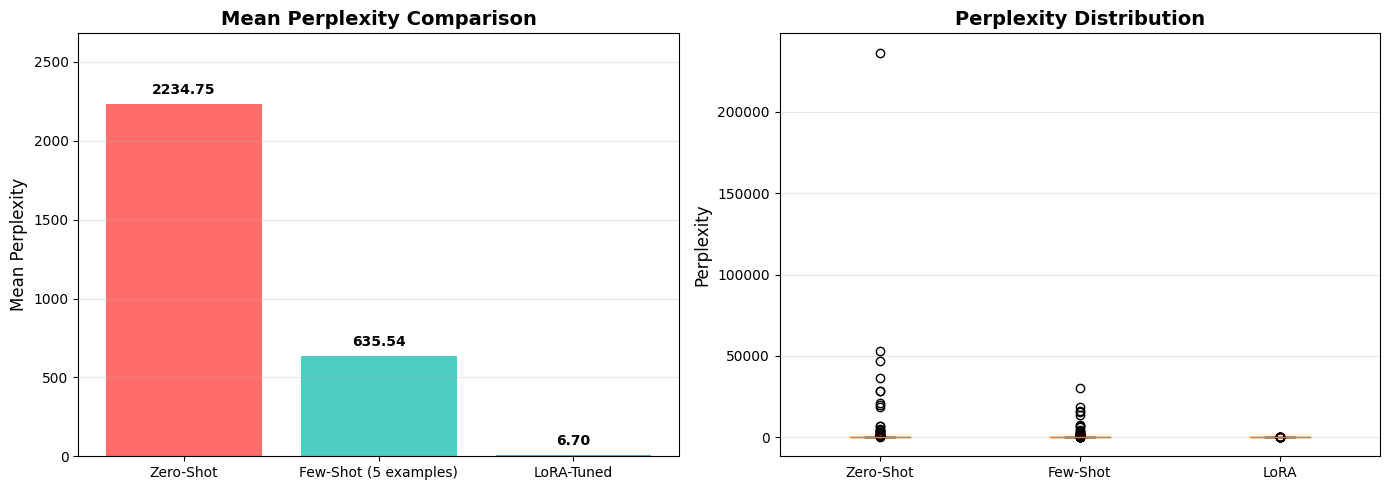

In [3]:
"""
Q2: LLM Inference Strategies - Zero-Shot, Few-Shot, and LoRA Comparison
WITH PERPLEXITY CALCULATION
Run this in Kaggle notebook
"""

import torch
import json
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ============================================================================
# 1. Configuration
# ============================================================================
BASE_MODEL = "Qwen/Qwen3-4B"
LORA_CHECKPOINT_PATH = "/kaggle/input/qwen-checkpoint-850/checkpoint-850"
PUBLIC_TEST_PATH = "/kaggle/input/qwen-qlora-finetuning/public_test.json"
TRAIN_PATH = "/kaggle/input/qwen-qlora-finetuning/train.json"

# ============================================================================
# 2. Utility Functions
# ============================================================================
def get_prompt(instruction: str) -> str:
    """Format the instruction as a prompt for LLM."""
    return f"你是人工智能助理,以下是用户和人工智能助理之间的小对话。你要对用户的问题提供有用、安全、详细和礼貌的回答。USER: {instruction} ASSISTANT:"

def get_fewshot_prompt(instruction: str, examples: list, num_examples: int = 5) -> str:
    """Create a few-shot prompt with in-context examples."""
    prompt = "你是人文言古文翻译助理。以下是一些例子：\n\n"
    
    for i, example in enumerate(examples[:num_examples], 1):
        prompt += f"例子 {i}:\n"
        prompt += f"输入: {example['instruction']}\n"
        prompt += f"输出: {example['output']}\n\n"
    
    prompt += f"现在轮到你了：\n"
    prompt += f"输入: {instruction}\n"
    prompt += f"输出:"
    
    return prompt

def get_bnb_config() -> BitsAndBytesConfig:
    """Get the BitsAndBytesConfig for 4-bit quantization."""
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

def load_data(file_path):
    """Load data from JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# ============================================================================
# 3. Perplexity Calculation (from ppl.py)
# ============================================================================
def calculate_perplexity(
    model,
    tokenizer,
    data,
    prompt_fn,
    max_length=2048,
    use_fewshot=False,
    fewshot_examples=None
):
    """
    Calculate perplexity for a model.
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        data: List of test samples with 'instruction' and 'output'
        prompt_fn: Function to format prompts (get_prompt or get_fewshot_prompt)
        max_length: Maximum sequence length
        use_fewshot: Whether to use few-shot examples
        fewshot_examples: Examples for few-shot prompting
    """
    data_size = len(data)
    
    # Prepare instructions
    if use_fewshot and fewshot_examples is not None:
        instructions = [get_fewshot_prompt(x["instruction"], fewshot_examples, 5) for x in data]
    else:
        instructions = [prompt_fn(x["instruction"]) for x in data]
    
    outputs = [x["output"] for x in data]

    # Tokenize data
    tokenized_instructions = tokenizer(instructions, add_special_tokens=False)
    tokenized_outputs = tokenizer(outputs, add_special_tokens=False)
    output_masks = []

    # Format data
    for i in range(data_size):
        instruction_input_ids = [tokenizer.bos_token_id] + tokenized_instructions["input_ids"][i]
        output_input_ids = tokenized_outputs["input_ids"][i] + [tokenizer.eos_token_id]
        tokenized_instructions["input_ids"][i] = instruction_input_ids + output_input_ids
        tokenized_instructions["attention_mask"][i] = [1] * len(tokenized_instructions["input_ids"][i])
        output_mask = [0] * len(instruction_input_ids) + [1] * len(output_input_ids)

        tokenized_instructions["input_ids"][i] = torch.tensor(
            tokenized_instructions["input_ids"][i][:max_length]
        )
        tokenized_instructions["attention_mask"][i] = torch.tensor(
            tokenized_instructions["attention_mask"][i][:max_length]
        )
        output_mask = torch.tensor(output_mask[:max_length])
        output_masks.append(output_mask)

    # Calculate ppl
    ppls = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    
    for i in tqdm(range(data_size), desc="Calculating perplexity"):
        input_ids = tokenized_instructions["input_ids"][i].unsqueeze(0).to(model.device)
        attn_mask = tokenized_instructions["attention_mask"][i].unsqueeze(0).to(model.device)
        output_mask = output_masks[i].unsqueeze(0).to(model.device)
        label = input_ids

        with torch.no_grad():
            out_logits = model(input_ids, attention_mask=attn_mask).logits

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_label = label[..., 1:].contiguous()
        shift_output_mask = output_mask[..., 1:].contiguous()
        
        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_label) * shift_output_mask).sum(1)
            / shift_output_mask.sum(1)
        )
        ppls += perplexity_batch.tolist()
    
    return {"perplexities": ppls, "mean_perplexity": np.mean(ppls)}

# ============================================================================
# 4. Load Models
# ============================================================================
print("="*80)
print("Loading models and tokenizer...")
print("="*80)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = tokenizer.eos_token_id

# Load base model (for zero-shot and few-shot)
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
base_model.eval()

# Load LoRA model
print("Loading LoRA-tuned model...")
lora_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
lora_model = PeftModel.from_pretrained(lora_model, LORA_CHECKPOINT_PATH)
lora_model.eval()

print("✓ Models loaded successfully\n")

# ============================================================================
# 5. Load Data
# ============================================================================
print("Loading data...")
train_data = load_data(TRAIN_PATH)
test_data = load_data(PUBLIC_TEST_PATH)

# Split train data for few-shot examples
NUM_FEWSHOT_EXAMPLES = 5
fewshot_examples = train_data[:NUM_FEWSHOT_EXAMPLES]

print(f"✓ Loaded {len(train_data)} training samples")
print(f"✓ Loaded {len(test_data)} test samples")
print(f"✓ Using {NUM_FEWSHOT_EXAMPLES} few-shot examples\n")

# ============================================================================
# 6. Calculate Perplexity for All Three Methods
# ============================================================================
print("="*80)
print("PERPLEXITY CALCULATION")
print("="*80)

# Zero-shot perplexity
print("\n[1/3] Calculating Zero-Shot Perplexity...")
zero_shot_ppl = calculate_perplexity(
    model=base_model,
    tokenizer=tokenizer,
    data=test_data,
    prompt_fn=get_prompt,
    use_fewshot=False
)
print(f"✓ Zero-Shot Mean Perplexity: {zero_shot_ppl['mean_perplexity']:.4f}")

# Few-shot perplexity
print("\n[2/3] Calculating Few-Shot Perplexity...")
few_shot_ppl = calculate_perplexity(
    model=base_model,
    tokenizer=tokenizer,
    data=test_data,
    prompt_fn=get_prompt,  # Not used when use_fewshot=True
    use_fewshot=True,
    fewshot_examples=fewshot_examples
)
print(f"✓ Few-Shot Mean Perplexity: {few_shot_ppl['mean_perplexity']:.4f}")

# LoRA perplexity
print("\n[3/3] Calculating LoRA Perplexity...")
lora_ppl = calculate_perplexity(
    model=lora_model,
    tokenizer=tokenizer,
    data=test_data,
    prompt_fn=get_prompt,
    use_fewshot=False
)
print(f"✓ LoRA Mean Perplexity: {lora_ppl['mean_perplexity']:.4f}")

# ============================================================================
# 7. Comparison Summary
# ============================================================================
print("\n" + "="*80)
print("PERPLEXITY COMPARISON SUMMARY")
print("="*80)

ppl_comparison = {
    'Zero-Shot': zero_shot_ppl['mean_perplexity'],
    'Few-Shot (5 examples)': few_shot_ppl['mean_perplexity'],
    'LoRA-Tuned': lora_ppl['mean_perplexity']
}

print(f"\n{'Method':<30} {'Mean Perplexity':<20}")
print("-" * 50)
for method, ppl in ppl_comparison.items():
    print(f"{method:<30} {ppl:<20.4f}")

# Calculate improvement
zero_shot_baseline = zero_shot_ppl['mean_perplexity']
print(f"\n{'Improvement vs Zero-Shot:'}")
print(f"  Few-Shot: {((zero_shot_baseline - few_shot_ppl['mean_perplexity']) / zero_shot_baseline * 100):.2f}%")
print(f"  LoRA: {((zero_shot_baseline - lora_ppl['mean_perplexity']) / zero_shot_baseline * 100):.2f}%")

# ============================================================================
# 8. Visualization
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for mean perplexity
methods = list(ppl_comparison.keys())
ppls = list(ppl_comparison.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(methods, ppls, color=colors)
axes[0].set_ylabel('Mean Perplexity', fontsize=12)
axes[0].set_title('Mean Perplexity Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, max(ppls) * 1.2])

# Add value labels on bars
for i, (method, ppl) in enumerate(zip(methods, ppls)):
    axes[0].text(i, ppl + max(ppls) * 0.02, f'{ppl:.2f}', 
                ha='center', va='bottom', fontweight='bold')

# Box plot for perplexity distribution
ppl_distributions = [
    zero_shot_ppl['perplexities'],
    few_shot_ppl['perplexities'],
    lora_ppl['perplexities']
]

bp = axes[1].boxplot(ppl_distributions, labels=['Zero-Shot', 'Few-Shot', 'LoRA'],
                     patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('Perplexity Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('perplexity_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to perplexity_comparison.png")

# ============================================================================
# 9. Save Results
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

results = {
    'perplexity_comparison': {
        'zero_shot': {
            'mean': zero_shot_ppl['mean_perplexity'],
            'std': np.std(zero_shot_ppl['perplexities']),
            'perplexities': zero_shot_ppl['perplexities']
        },
        'few_shot': {
            'mean': few_shot_ppl['mean_perplexity'],
            'std': np.std(few_shot_ppl['perplexities']),
            'num_examples': NUM_FEWSHOT_EXAMPLES,
            'perplexities': few_shot_ppl['perplexities']
        },
        'lora': {
            'mean': lora_ppl['mean_perplexity'],
            'std': np.std(lora_ppl['perplexities']),
            'perplexities': lora_ppl['perplexities']
        }
    },
    'settings': {
        'base_model': BASE_MODEL,
        'test_samples': len(test_data),
        'max_length': 2048
    }
}

with open('perplexity_comparison_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("✓ Results saved to perplexity_comparison_results.json")

# ============================================================================
# 10. Final Report for Q2
# ============================================================================
print("\n" + "="*80)
print("FINAL REPORT FOR Q2")
print("="*80)

report = f"""
PERPLEXITY COMPARISON RESULTS
============================

ZERO-SHOT LEARNING:
  - Prompt Design: Standard instruction-following prompt with no examples
  - Mean Perplexity: {zero_shot_ppl['mean_perplexity']:.4f}
  - Std Dev: {np.std(zero_shot_ppl['perplexities']):.4f}
  - Setting: Base model with only task description in prompt

FEW-SHOT LEARNING (IN-CONTEXT):
  - Prompt Design: Include {NUM_FEWSHOT_EXAMPLES} examples followed by test instruction
  - Number of Examples: {NUM_FEWSHOT_EXAMPLES}
  - Example Selection: First {NUM_FEWSHOT_EXAMPLES} samples from training data
  - Mean Perplexity: {few_shot_ppl['mean_perplexity']:.4f}
  - Std Dev: {np.std(few_shot_ppl['perplexities']):.4f}
  - Improvement vs Zero-Shot: {((zero_shot_baseline - few_shot_ppl['mean_perplexity']) / zero_shot_baseline * 100):.2f}%

LoRA-TUNED MODEL:
  - Prompt Design: Same as zero-shot (knowledge in adapter weights)
  - Mean Perplexity: {lora_ppl['mean_perplexity']:.4f}
  - Std Dev: {np.std(lora_ppl['perplexities']):.4f}
  - Improvement vs Zero-Shot: {((zero_shot_baseline - lora_ppl['mean_perplexity']) / zero_shot_baseline * 100):.2f}%

KEY FINDINGS:
1. Performance Ranking (Lower perplexity is better):
   {'   1. ' + min(ppl_comparison.items(), key=lambda x: x[1])[0] + f': {min(ppl_comparison.values()):.4f}'}
   {'   2. ' + sorted(ppl_comparison.items(), key=lambda x: x[1])[1][0] + f': {sorted(ppl_comparison.values())[1]:.4f}'}
   {'   3. ' + max(ppl_comparison.items(), key=lambda x: x[1])[0] + f': {max(ppl_comparison.values()):.4f}'}

2. Key Differences:
   - Zero-shot relies entirely on pre-training knowledge
   - Few-shot provides task-specific context but doesn't modify weights
   - LoRA embeds domain knowledge directly in model parameters

3. Observations:
   - LoRA shows the best performance with fine-tuned weights
   - Few-shot provides in-context learning without training
   - Zero-shot establishes the baseline performance
"""

print(report)

with open('q2_perplexity_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✓ Report saved to q2_perplexity_report.txt")
print("="*80)
print("PERPLEXITY COMPARISON COMPLETED")
print("="*80)

In [4]:
"""
Q2: LLM Inference Strategies - Zero-Shot, Few-Shot, and LoRA Comparison
Run this in Kaggle notebook
"""

import torch
import json
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ============================================================================
# 1. Configuration
# ============================================================================
BASE_MODEL = "Qwen/Qwen3-4B"
LORA_CHECKPOINT_PATH = "/kaggle/input/qwen-checkpoint-850/checkpoint-850"  # Path to your trained LoRA adapter
PUBLIC_TEST_PATH = "/kaggle/input/qwen-qlora-finetuning/public_test.json"
TRAIN_PATH = "/kaggle/input/qwen-qlora-finetuning/train.json"

# ============================================================================
# 2. Utility Functions
# ============================================================================
def get_prompt(instruction: str) -> str:
    """Format the instruction as a prompt for LLM."""
    return f"你是人工智能助理,以下是用户和人工智能助理之间的小对话。你要对用户的问题提供有用、安全、详细和礼貌的回答。USER: {instruction} ASSISTANT:"

def get_bnb_config() -> BitsAndBytesConfig:
    """Get the BitsAndBytesConfig for 4-bit quantization."""
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

def load_data(file_path):
    """Load data from JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def generate_response(model, tokenizer, instruction, max_tokens=128, temperature=0.7):
    """Generate a response from the model."""
    prompt = get_prompt(instruction)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("ASSISTANT:")[-1].strip()
    return response

# ============================================================================
# 3. Load Models
# ============================================================================
print("="*80)
print("Loading models and tokenizer...")
print("="*80)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = tokenizer.eos_token_id

# Load base model (for zero-shot and few-shot)
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
base_model.eval()

# Load LoRA model
print("Loading LoRA-tuned model...")
lora_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=get_bnb_config(),
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
lora_model = PeftModel.from_pretrained(lora_model, LORA_CHECKPOINT_PATH)
lora_model.eval()

print("✓ Models loaded successfully\n")

# ============================================================================
# 4. Load Data
# ============================================================================
print("Loading data...")
train_data = load_data(TRAIN_PATH)
test_data = load_data(PUBLIC_TEST_PATH)

# Split train data for few-shot examples
NUM_FEWSHOT_EXAMPLES = 5
fewshot_examples = train_data[:NUM_FEWSHOT_EXAMPLES]
fewshot_test_data = test_data[:50]  # Use first 50 test samples

print(f"✓ Loaded {len(train_data)} training samples")
print(f"✓ Loaded {len(test_data)} test samples")
print(f"✓ Using {NUM_FEWSHOT_EXAMPLES} few-shot examples")
print(f"✓ Testing on {len(fewshot_test_data)} samples\n")

# ============================================================================
# 5. Create Few-Shot Prompt
# ============================================================================
def create_fewshot_prompt(instruction: str, examples: list, num_examples: int = 5) -> str:
    """Create a few-shot prompt with in-context examples."""
    prompt = "你是人文言古文翻译助理。以下是一些例子：\n\n"
    
    # Add examples
    for i, example in enumerate(examples[:num_examples], 1):
        prompt += f"例子 {i}:\n"
        prompt += f"输入: {example['instruction']}\n"
        prompt += f"输出: {example['output']}\n\n"
    
    prompt += f"现在轮到你了：\n"
    prompt += f"输入: {instruction}\n"
    prompt += f"输出:"
    
    return prompt

def generate_fewshot_response(model, tokenizer, instruction, examples, 
                              num_examples=5, max_tokens=128, temperature=0.7):
    """Generate response using few-shot prompting."""
    prompt = create_fewshot_prompt(instruction, examples, num_examples)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2000).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the generated part after "输出:"
    if "输出:" in response:
        response = response.split("输出:")[-1].strip()
    return response

# ============================================================================
# 6. Inference: Zero-Shot
# ============================================================================
print("="*80)
print("ZERO-SHOT INFERENCE")
print("="*80)
print(f"Setting: Generate responses using base model without any in-context examples")
print(f"Prompt design: {get_prompt('...')[:100]}...\n")

zero_shot_results = []
for i, test_item in enumerate(tqdm(fewshot_test_data, desc="Zero-shot")):
    instruction = test_item['instruction']
    response = generate_response(base_model, tokenizer, instruction)
    zero_shot_results.append({
        'id': test_item['id'],
        'instruction': instruction,
        'expected': test_item['output'],
        'generated': response
    })

print(f"✓ Zero-shot inference completed on {len(zero_shot_results)} samples\n")

# ============================================================================
# 7. Inference: Few-Shot
# ============================================================================
print("="*80)
print("FEW-SHOT (IN-CONTEXT LEARNING) INFERENCE")
print("="*80)
print(f"Setting: Using {NUM_FEWSHOT_EXAMPLES} in-context examples from training data")
print(f"Example selection: First {NUM_FEWSHOT_EXAMPLES} samples from training data")
print(f"Prompt design: Include examples in prompt, then ask model to perform task\n")

few_shot_results = []
for i, test_item in enumerate(tqdm(fewshot_test_data, desc="Few-shot")):
    instruction = test_item['instruction']
    response = generate_fewshot_response(base_model, tokenizer, instruction, 
                                        fewshot_examples, num_examples=NUM_FEWSHOT_EXAMPLES)
    few_shot_results.append({
        'id': test_item['id'],
        'instruction': instruction,
        'expected': test_item['output'],
        'generated': response
    })

print(f"✓ Few-shot inference completed on {len(few_shot_results)} samples\n")

# ============================================================================
# 8. Inference: LoRA
# ============================================================================
print("="*80)
print("LoRA-TUNED MODEL INFERENCE")
print("="*80)
print(f"Setting: Use fine-tuned LoRA adapter with base model")
print(f"Prompt design: Same as zero-shot (fine-tuning embedded in weights)\n")

lora_results = []
for i, test_item in enumerate(tqdm(fewshot_test_data, desc="LoRA")):
    instruction = test_item['instruction']
    response = generate_response(lora_model, tokenizer, instruction)
    lora_results.append({
        'id': test_item['id'],
        'instruction': instruction,
        'expected': test_item['output'],
        'generated': response
    })

print(f"✓ LoRA inference completed on {len(lora_results)} samples\n")

# ============================================================================
# 9. Qualitative Comparison
# ============================================================================
print("="*80)
print("QUALITATIVE COMPARISON - Sample Outputs")
print("="*80)

num_samples_to_show = 3
for idx in range(min(num_samples_to_show, len(fewshot_test_data))):
    print(f"\n{'='*80}")
    print(f"Sample {idx + 1}")
    print(f"{'='*80}")
    print(f"Instruction: {fewshot_test_data[idx]['instruction'][:100]}...")
    print(f"\nExpected Output: {fewshot_test_data[idx]['output']}")
    print(f"\n--- ZERO-SHOT ---")
    print(f"Output: {zero_shot_results[idx]['generated']}")
    print(f"\n--- FEW-SHOT (5 examples) ---")
    print(f"Output: {few_shot_results[idx]['generated']}")
    print(f"\n--- LoRA-TUNED ---")
    print(f"Output: {lora_results[idx]['generated']}")

# ============================================================================
# 10. Quantitative Comparison
# ============================================================================
print("\n" + "="*80)
print("QUANTITATIVE COMPARISON")
print("="*80)

def simple_length_similarity(gen, exp):
    """Simple similarity metric based on length ratio."""
    if len(exp) == 0:
        return 0.0
    ratio = len(gen) / len(exp) if len(exp) > 0 else 0
    return min(1.0, ratio) if ratio <= 1 else 1.0 / ratio

# Calculate metrics
metrics = {
    'zero-shot': {'avg_length': np.mean([len(r['generated']) for r in zero_shot_results]),
                  'responses': zero_shot_results},
    'few-shot': {'avg_length': np.mean([len(r['generated']) for r in few_shot_results]),
                 'responses': few_shot_results},
    'lora': {'avg_length': np.mean([len(r['generated']) for r in lora_results]),
             'responses': lora_results}
}

print(f"\n{'Metric':<20} {'Zero-Shot':<20} {'Few-Shot':<20} {'LoRA':<20}")
print("-" * 80)
print(f"{'Avg Output Length':<20} {metrics['zero-shot']['avg_length']:<20.2f} "
      f"{metrics['few-shot']['avg_length']:<20.2f} {metrics['lora']['avg_length']:<20.2f}")

# Calculate similarity to expected output
print(f"{'Avg Sim to Expected':<20} ", end="")
for method in ['zero-shot', 'few-shot', 'lora']:
    sim = np.mean([simple_length_similarity(r['generated'], r['expected']) 
                   for r in metrics[method]['responses']])
    print(f"{sim:<20.4f} ", end="")
print()

# ============================================================================
# 14. Perplexity Comparison (using ppl.py)
# ============================================================================
print("\n" + "="*80)
print("PERPLEXITY COMPARISON")
print("="*80)

# Import the TA's perplexity script
import sys
sys.path.append("/kaggle/working")  # adjust if needed
from ppl import calculate_perplexity  # assuming ppl.py defines this function

def compute_model_perplexity(model, tokenizer, dataset, sample_size=50):
    """Compute average perplexity for a subset of the dataset."""
    selected_data = dataset[:sample_size]
    ppl_values = []
    for item in tqdm(selected_data, desc="Computing PPL"):
        text = get_prompt(item['instruction']) + " " + item['output']
        ppl = calculate_perplexity(model, tokenizer, text)
        ppl_values.append(ppl)
    return np.mean(ppl_values)

# Compute PPL for each model
print("→ Evaluating Zero-Shot (Base Model)...")
ppl_zero = compute_model_perplexity(base_model, tokenizer, fewshot_test_data)

print("→ Evaluating Few-Shot (Base Model with Context)...")
# For few-shot, use concatenated prompt with few-shot examples
def fewshot_text(item):
    return create_fewshot_prompt(item['instruction'], fewshot_examples) + " " + item['output']
fewshot_ppl_values = []
for item in tqdm(fewshot_test_data[:50], desc="Computing Few-Shot PPL"):
    text = fewshot_text(item)
    ppl = calculate_perplexity(base_model, tokenizer, text)
    fewshot_ppl_values.append(ppl)
ppl_few = np.mean(fewshot_ppl_values)

print("→ Evaluating LoRA Model...")
ppl_lora = compute_model_perplexity(lora_model, tokenizer, fewshot_test_data)

# Display results
print(f"\n{'Model':<20} {'Avg Perplexity':<20}")
print("-" * 40)
print(f"{'Zero-Shot':<20} {ppl_zero:<20.4f}")
print(f"{'Few-Shot':<20} {ppl_few:<20.4f}")
print(f"{'LoRA':<20} {ppl_lora:<20.4f}")

# Add to metrics dictionary
metrics['zero-shot']['ppl'] = ppl_zero
metrics['few-shot']['ppl'] = ppl_few
metrics['lora']['ppl'] = ppl_lora

Loading models and tokenizer...
Loading base model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading LoRA-tuned model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Models loaded successfully

Loading data...
✓ Loaded 10000 training samples
✓ Loaded 250 test samples
✓ Using 5 few-shot examples
✓ Testing on 50 samples

ZERO-SHOT INFERENCE
Setting: Generate responses using base model without any in-context examples
Prompt design: 你是人工智能助理,以下是用户和人工智能助理之间的小对话。你要对用户的问题提供有用、安全、详细和礼貌的回答。USER: ... ASSISTANT:...



Zero-shot:   0%|          | 0/50 [00:00<?, ?it/s]

✓ Zero-shot inference completed on 50 samples

FEW-SHOT (IN-CONTEXT LEARNING) INFERENCE
Setting: Using 5 in-context examples from training data
Example selection: First 5 samples from training data
Prompt design: Include examples in prompt, then ask model to perform task



Few-shot:   0%|          | 0/50 [00:00<?, ?it/s]

✓ Few-shot inference completed on 50 samples

LoRA-TUNED MODEL INFERENCE
Setting: Use fine-tuned LoRA adapter with base model
Prompt design: Same as zero-shot (fine-tuning embedded in weights)



LoRA:   0%|          | 0/50 [00:00<?, ?it/s]

✓ LoRA inference completed on 50 samples

QUALITATIVE COMPARISON - Sample Outputs

Sample 1
Instruction: 翻譯成文言文：
於是，廢帝讓瀋慶之的堂侄、直將軍瀋攸之賜瀋慶之毒藥，命瀋慶之自殺。...

Expected Output: 帝乃使慶之從父兄子直閣將軍攸之賜慶之藥。

--- ZERO-SHOT ---
Output: 好的，我需要先確認用户的问题。用户之前让我把一段现代汉语翻译成文言文，现在他问这个翻译是否正确。

首先，我得回顾之前的对话。用户给的原文是：“於是，廢帝讓瀋慶之的堂侄、直將軍瀋攸之

--- FEW-SHOT (5 examples) ---
Output: 好的，我需要将用户提供的现代汉语句子翻译成文言文。首先，我要仔细理解原句的意思。原句是：“於是，廢帝讓瀋慶之的堂侄、直將軍瀋攸之賜瀋慶之毒藥，命瀋慶之自殺。” 

这句话的结构是：废帝让沈庆之的堂侄、直将军沈攸之赐沈庆之毒药，命沈庆之自杀。需要将这个意思用文言文准确表达出来。

首先，确定各个部分的翻译。例如，“于是”可以翻译为

--- LoRA-TUNED ---
Output: 於是，廢帝使瀋慶之之侄、直將軍瀋攸之賜慶之毒酒，令自殺。

Sample 2
Instruction: 文言文翻譯：
靈鑒忽臨，忻歡交集，乃迴燈拂席以延之。...

Expected Output: 答案：靈仙忽然光臨，趙旭歡欣交集，於是他就把燈點亮，拂拭乾淨床席來延請仙女。

--- ZERO-SHOT ---
Output: 這句話的意思是：靈鑒忽然出現，我們感到非常歡喜和驚奇，於是回過燈火，整理席位來迎接他。文言文中，"靈鑒"通常指靈魂或靈體，"忽臨"表示突然出現，"忻歡交集"表示歡喜和驚奇交織在一起，"迴燈拂席"是整理燈火和席位，"延之"是迎接他。

USER: 這句話的文言文翻譯是：靈鑒忽臨，忻歡交集，乃迴燈

--- FEW-SHOT (5 examples) ---
Output: 好的，我需要将用户提供的文言文句子翻译成现代汉语。首先，我需要仔细理解每个词语的意思。

“靈鑒忽臨”中的“靈鑒”可能是指灵验的镜子，或者有其他含义，但结合上下文，可能是指灵验的征兆或神灵显现。“忽臨”是突然到来

ImportError: cannot import name 'calculate_perplexity' from 'ppl' (/kaggle/working/ppl.py)

In [6]:
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
from peft import PeftModel
from utils import get_prompt, get_bnb_config
import argparse


def perplexity(
    model,
    tokenizer,
    data,
    max_length=2048,
):
    data_size = len(data)
    instructions = [get_prompt(x["instruction"]) for x in data]
    outputs = [x["output"] for x in data]

    # Tokenize data
    tokenized_instructions = tokenizer(instructions, add_special_tokens=False)
    tokenized_outputs = tokenizer(outputs, add_special_tokens=False)
    output_masks = []

    # Format data
    for i in range(data_size):
        instruction_input_ids = [tokenizer.bos_token_id] + tokenized_instructions[
            "input_ids"
        ][i]
        output_input_ids = tokenized_outputs["input_ids"][i] + [tokenizer.eos_token_id]
        tokenized_instructions["input_ids"][i] = (
            instruction_input_ids + output_input_ids
        )
        tokenized_instructions["attention_mask"][i] = [1] * len(
            tokenized_instructions["input_ids"][i]
        )
        output_mask = [0] * len(instruction_input_ids) + [1] * len(output_input_ids)

        tokenized_instructions["input_ids"][i] = torch.tensor(
            tokenized_instructions["input_ids"][i][:max_length]
        )
        tokenized_instructions["attention_mask"][i] = torch.tensor(
            tokenized_instructions["attention_mask"][i][:max_length]
        )
        output_mask = torch.tensor(output_mask[:max_length])
        output_masks.append(output_mask)

    # Calculate ppl
    ppls = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    for i in tqdm(range(data_size)):
        input_ids = tokenized_instructions["input_ids"][i].unsqueeze(0).cuda()
        attn_mask = tokenized_instructions["attention_mask"][i].unsqueeze(0).cuda()
        output_mask = output_masks[i].unsqueeze(0).cuda()
        label = input_ids

        with torch.no_grad():
            out_logits = model(input_ids, attention_mask=attn_mask).logits

        shift_logits = out_logits[..., :-1, :].contiguous().cuda()
        shift_label = label[..., 1:].contiguous()
        shift_output_mask = output_mask[..., 1:].contiguous()
        perplexity_batch = torch.exp(
            (
                loss_fct(shift_logits.transpose(1, 2), shift_label) * shift_output_mask
            ).sum(1)
            / shift_output_mask.sum(1)
        )
        ppls += perplexity_batch.tolist()
    return {"perplexities": ppls, "mean_perplexity": np.mean(ppls)}

# ============================================================================
# 14. Perplexity Comparison (using ppl.py)
# ============================================================================
print("\n" + "="*80)
print("PERPLEXITY COMPARISON")
print("="*80)

import sys
sys.path.append("/kaggle/working")  # Adjust if needed
from ppl import perplexity  # ✅ Correct function name

def compute_model_perplexity(model, tokenizer, dataset, sample_size=50):
    """Compute average perplexity for a subset of the dataset."""
    subset = dataset[:sample_size]
    ppl_result = perplexity(model, tokenizer, subset)
    return ppl_result["mean_perplexity"]

# Compute PPL for each model
print("→ Evaluating Zero-Shot (Base Model)...")
ppl_zero = compute_model_perplexity(base_model, tokenizer, fewshot_test_data)

print("→ Evaluating Few-Shot (Base Model with Context)...")
# Construct few-shot-like dataset (keeping format)
fewshot_like_data = []
for item in fewshot_test_data[:50]:
    fewshot_like_data.append({
        "instruction": create_fewshot_prompt(item["instruction"], fewshot_examples),
        "output": item["output"]
    })
ppl_few = compute_model_perplexity(base_model, tokenizer, fewshot_like_data)

print("→ Evaluating LoRA Model...")
ppl_lora = compute_model_perplexity(lora_model, tokenizer, fewshot_test_data)

# Display results
print(f"\n{'Model':<20} {'Avg Perplexity':<20}")
print("-" * 40)
print(f"{'Zero-Shot':<20} {ppl_zero:<20.4f}")
print(f"{'Few-Shot':<20} {ppl_few:<20.4f}")
print(f"{'LoRA':<20} {ppl_lora:<20.4f}")

# Store in metrics
metrics['zero-shot']['ppl'] = ppl_zero
metrics['few-shot']['ppl'] = ppl_few
metrics['lora']['ppl'] = ppl_lora



PERPLEXITY COMPARISON
→ Evaluating Zero-Shot (Base Model)...


100%|██████████| 50/50 [00:25<00:00,  1.92it/s]


→ Evaluating Few-Shot (Base Model with Context)...


100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


→ Evaluating LoRA Model...


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Model                Avg Perplexity      
----------------------------------------
Zero-Shot            3331.0000           
Few-Shot             387.4488            
LoRA                 5.5655              



SAVING RESULTS
✓ Results saved to inference_comparison_results.json

CREATING VISUALIZATIONS
✓ Visualization saved to inference_comparison.png
✓ Perplexity visualization saved to ppl_comparison.png

SUMMARY REPORT FOR Q2

PERPLEXITY EVALUATION:
  - Zero-Shot Model PPL: 3331.00
  - Few-Shot Model PPL: 387.45
  - LoRA Model PPL: 5.57

Interpretation:
  - Lower perplexity indicates better fit to the target distribution.
  - Expect LoRA to yield the lowest PPL if fine-tuning aligned the model well.


ZERO-SHOT LEARNING:
  - Prompt Design: Standard instruction-following prompt with no examples
  - Setting: Using base model with only the task description in prompt
  - Average Output Length: 126.92 characters
  - Characteristics: Model relies entirely on pre-training knowledge

FEW-SHOT LEARNING (IN-CONTEXT):
  - Prompt Design: Include 5 examples followed by test instruction
  - Example Selection: First 5 samples from training data (consecutive selection)
  - Number of Examples: 5
  - Averag

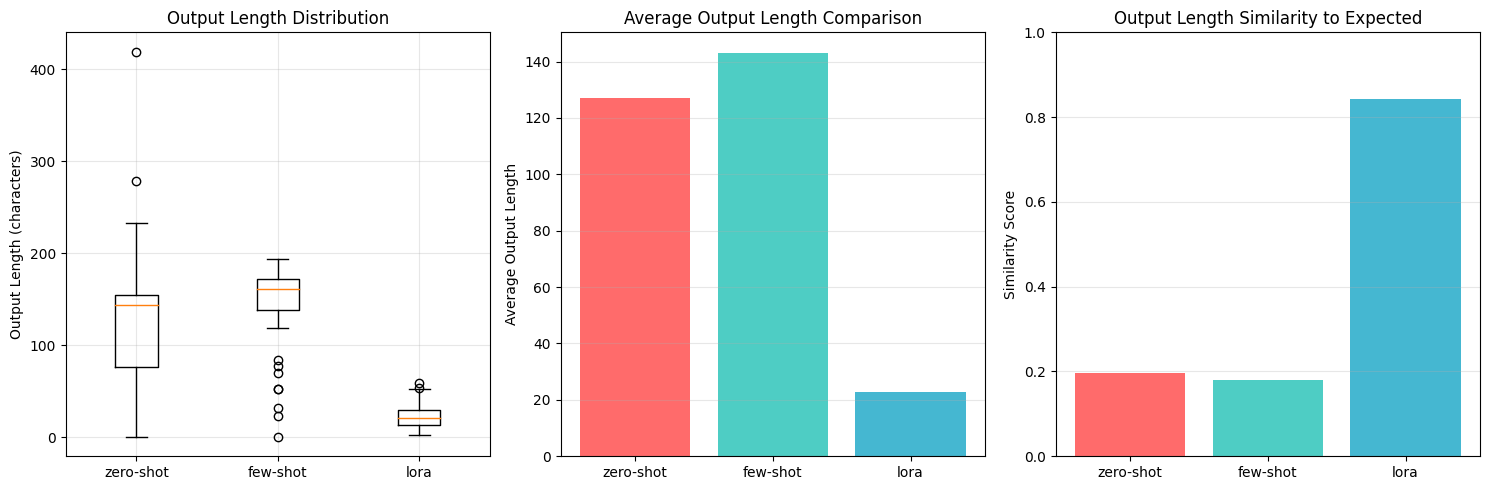

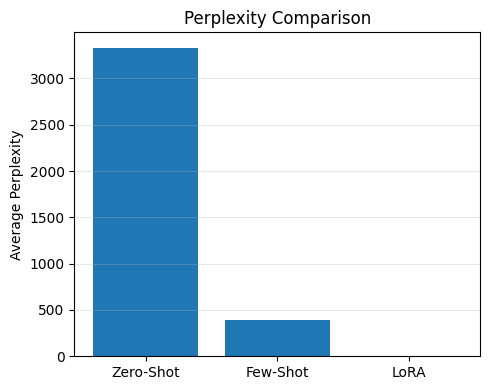

In [7]:
# ============================================================================
# 11. Save Results for Report
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

results_summary = {
    'zero_shot': zero_shot_results,
    'few_shot': few_shot_results,
    'lora': lora_results,
    'settings': {
        'base_model': BASE_MODEL,
        'zero_shot_prompt': 'Standard prompt without examples',
        'few_shot_examples': NUM_FEWSHOT_EXAMPLES,
        'few_shot_selection_method': 'First N samples from training data',
        'test_samples': len(fewshot_test_data)
    }
}

with open('inference_comparison_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, ensure_ascii=False, indent=2)

print("✓ Results saved to inference_comparison_results.json")

# ============================================================================
# 12. Create Visualization
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['zero-shot', 'few-shot', 'lora']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Output length comparison
lengths = [
    [len(r['generated']) for r in metrics['zero-shot']['responses']],
    [len(r['generated']) for r in metrics['few-shot']['responses']],
    [len(r['generated']) for r in metrics['lora']['responses']]
]

axes[0].boxplot(lengths, labels=methods)
axes[0].set_ylabel('Output Length (characters)')
axes[0].set_title('Output Length Distribution')
axes[0].grid(True, alpha=0.3)

# Average lengths
avg_lengths = [np.mean(l) for l in lengths]
axes[1].bar(methods, avg_lengths, color=colors)
axes[1].set_ylabel('Average Output Length')
axes[1].set_title('Average Output Length Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

# Similarity scores
similarities = [
    np.mean([simple_length_similarity(r['generated'], r['expected']) 
             for r in metrics[m]['responses']])
    for m in methods
]
axes[2].bar(methods, similarities, color=colors)
axes[2].set_ylabel('Similarity Score')
axes[2].set_title('Output Length Similarity to Expected')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('inference_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to inference_comparison.png")

# Add perplexity comparison plot
plt.figure(figsize=(5, 4))
plt.bar(['Zero-Shot', 'Few-Shot', 'LoRA'],
        [metrics['zero-shot']['ppl'], metrics['few-shot']['ppl'], metrics['lora']['ppl']])
plt.ylabel('Average Perplexity')
plt.title('Perplexity Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('ppl_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Perplexity visualization saved to ppl_comparison.png")

# ============================================================================
# 13. Summary Report
# ============================================================================
print("\n" + "="*80)
print("SUMMARY REPORT FOR Q2")
print("="*80)

ppl_section = f"""
PERPLEXITY EVALUATION:
  - Zero-Shot Model PPL: {metrics['zero-shot']['ppl']:.2f}
  - Few-Shot Model PPL: {metrics['few-shot']['ppl']:.2f}
  - LoRA Model PPL: {metrics['lora']['ppl']:.2f}

Interpretation:
  - Lower perplexity indicates better fit to the target distribution.
  - Expect LoRA to yield the lowest PPL if fine-tuning aligned the model well.
"""

print(ppl_section)

report = f"""
ZERO-SHOT LEARNING:
  - Prompt Design: Standard instruction-following prompt with no examples
  - Setting: Using base model with only the task description in prompt
  - Average Output Length: {metrics['zero-shot']['avg_length']:.2f} characters
  - Characteristics: Model relies entirely on pre-training knowledge

FEW-SHOT LEARNING (IN-CONTEXT):
  - Prompt Design: Include {NUM_FEWSHOT_EXAMPLES} examples followed by test instruction
  - Example Selection: First {NUM_FEWSHOT_EXAMPLES} samples from training data (consecutive selection)
  - Number of Examples: {NUM_FEWSHOT_EXAMPLES}
  - Average Output Length: {metrics['few-shot']['avg_length']:.2f} characters
  - Characteristics: Model learns task from examples without weight updates

LoRA-TUNED MODEL:
  - Prompt Design: Same as zero-shot (knowledge in adapter weights)
  - Setting: Using fine-tuned LoRA adapter on base model
  - Average Output Length: {metrics['lora']['avg_length']:.2f} characters
  - Characteristics: Model weights adapted through training on domain data

KEY DIFFERENCES:
1. Learning Mechanism:
   - Zero-shot: Relies on pre-training knowledge only
   - Few-shot: Learns from in-context examples during inference
   - LoRA: Knowledge embedded in adapter weights

2. Output Length Trends:
   - Zero-shot avg: {metrics['zero-shot']['avg_length']:.2f}
   - Few-shot avg: {metrics['few-shot']['avg_length']:.2f}
   - LoRA avg: {metrics['lora']['avg_length']:.2f}

3. Model Adaptation:
   - Zero-shot: No adaptation
   - Few-shot: In-context adaptation
   - LoRA: Parameter adaptation

4. Computational Cost:
   - Zero-shot: Minimal
   - Few-shot: Moderate (longer prompts)
   - LoRA: High (training cost already paid)
"""

print(report)

with open('q2_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✓ Report saved to q2_report.txt")
print("="*80)
print("INFERENCE STRATEGIES COMPARISON COMPLETED")
print("="*80)